Comments for the corrector:
1. Careful with the label after KMEANS to identify outliers. Sometimes outliers are labeled with 1 and others with 0.


# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# magic word for producing visualizations in notebook
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Imputer
from sklearn import preprocessing
from sklearn.decomposition import PCA
import pickle as pk
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
azdias.head()

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                      4                 5    ...            2.0         3.0   
2                      3                 5    ...            3.0         3.0   
3                      1                 2    ...            2.0         2.0   
4                      3                 2    ...            2.0         4.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   
2         1.0         0.0          1.0       4.0       4.0     3.0   
3         2.0         0.0          1.0       3.0       4.0     2.0   
4         2.0         1.0          2.0       3.0       3.0     4.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  
2          5.0       2.0  
3          3.0       3.0  
4          6.0       5.0  

[5 rows x 85 columns]

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.describe()

AGER_TYP  ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP  \
count  891221.000000         891221.000000  891221.000000  886367.000000   
mean       -0.358435              2.777398       1.522098       3.632838   
std         1.198724              1.068775       0.499512       1.595021   
min        -1.000000              1.000000       1.000000       1.000000   
25%        -1.000000              2.000000       1.000000       2.000000   
50%        -1.000000              3.000000       2.000000       4.000000   
75%        -1.000000              4.000000       2.000000       5.000000   
max         3.000000              9.000000       2.000000       6.000000   

       FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
count      891221.000000  891221.000000     891221.000000   891221.000000   
mean            3.074528       2.821039          3.401106        3.033328   
std             1.321055       1.464749          1.322134        1.529603   
min             1.000000       1.000000          1.000000        1.000000   
25%             2.000000       1.000000          3.000000        2.000000   
50%             3.000000       3.000000          3.000000        3.000000   
75%             4.000000       4.000000          5.000000        5.000000   
max             5.000000       5.000000          5.000000        5.000000   

       FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER      ...          PLZ8_ANTG1  \
count          891221.000000     891221.000000      ...       774706.000000   
mean                2.874167          3.075121      ...            2.253330   
std                 1.486731          1.353248      ...            0.972008   
min                 1.000000          1.000000      ...            0.000000   
25%                 2.000000          2.000000      ...            1.000000   
50%                 3.000000          3.000000      ...            2.000000   
75%                 4.000000          4.000000      ...            3.000000   
max                 5.000000          5.000000      ...            4.000000   

          PLZ8_ANTG2     PLZ8_ANTG3     PLZ8_ANTG4    PLZ8_BAUMAX  \
count  774706.000000  774706.000000  774706.000000  774706.000000   
mean        2.801858       1.595426       0.699166       1.943913   
std         0.920309       0.986736       0.727137       1.459654   
min         0.000000       0.000000       0.000000       1.000000   
25%         2.000000       1.000000       0.000000       1.000000   
50%         3.000000       2.000000       1.000000       1.000000   
75%         3.000000       2.000000       1.000000       3.000000   
max         4.000000       3.000000       2.000000       5.000000   

            PLZ8_HHZ       PLZ8_GBZ         ARBEIT    ORTSGR_KLS9  \
count  774706.000000  774706.000000  794005.000000  794005.000000   
mean        3.612821       3.381087       3.167854       5.293002   
std         0.973967       1.111598       1.002376       2.303739   
min         1.000000       1.000000       1.000000       0.000000   
25%         3.000000       3.000000       3.000000       4.000000   
50%         4.000000       3.000000       3.000000       5.000000   
75%         4.000000       4.000000       4.000000       7.000000   
max         5.000000       5.000000       9.000000       9.000000   

           RELAT_AB  
count  794005.00000  
mean        3.07222  
std         1.36298  
min         1.00000  
25%         2.00000  
50%         3.00000  
75%         4.00000  
max         9.00000  

[8 rows x 81 columns]

In [5]:
feat_info

attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric                [0]
12        GFK_URLAUBERTYP            person  categorical                 []
13       GREEN_AVANTGARDE            person  categorical                 []
14             HEALTH_TYP            person      ordinal             [-1,0]
15    LP_LEBENSPHASE_FEIN            person        mixed                [0]
16    LP_LEBENSPHASE_GROB            person        mixed                [0]
17        LP_FAMILIE_FEIN            person  categorical                [0]
18        LP_FAMILIE_GROB            person  categorical                [0]
19         LP_STATUS_FEIN            person  categorical                [0]
20         LP_STATUS_GROB            person  categorical                [0]
21       NATIONALITAET_KZ            person  categorical             [-1,0]
22  PRAEGENDE_JUGENDJAHRE            person        mixed             [-1,0]
23         RETOURTYP_BK_S            person      ordinal                [0]
24              SEMIO_SOZ            person      ordinal             [-1,9]
25              SEMIO_FAM            person      ordinal             [-1,9]
26              SEMIO_REL            person      ordinal             [-1,9]
27              SEMIO_MAT            person      ordinal             [-1,9]
28             SEMIO_VERT            person      ordinal             [-1,9]
29             SEMIO_LUST            person      ordinal             [-1,9]
..                    ...               ...          ...                ...
55            OST_WEST_KZ          building  categorical               [-1]
56               WOHNLAGE          building        mixed               [-1]
57        CAMEO_DEUG_2015     microcell_rr4  categorical             [-1,X]
58         CAMEO_DEU_2015     microcell_rr4  categorical               [XX]
59        CAMEO_INTL_2015     microcell_rr4        mixed            [-1,XX]
60            KBA05_ANTG1     microcell_rr3      ordinal               [-1]
61            KBA05_ANTG2     microcell_rr3      ordinal               [-1]
62            KBA05_ANTG3     microcell_rr3      ordinal               [-1]
63            KBA05_ANTG4     microcell_rr3      ordinal               [-1]
64           KBA05_BAUMAX     microcell_rr3        mixed             [-1,0]
65              KBA05_GBZ     microcell_rr3      ordinal             [-1,0]
66               BALLRAUM          postcode      ordinal               [-1]
67               EWDICHTE          postcode      ordinal               [-1]
68             INNENSTADT          postcode      ordinal               [-1]
69     GEBAEUDETYP_RASTER        region_rr1      ordinal                 []
70                    KKK        region_rr1      ordinal             [-1,0]
71             MOBI_REGIO        region_rr1      ordinal                 []
72      ONLINE_AFFINITAET        region_rr1      ordinal                 []
73               REGIOTYP        region_rr1      ordinal             [-1,0]
74       KBA13_ANZAHL_PKW    macrocell_plz8      numeric                 []
75             PLZ8_ANTG1    macrocell_plz8      ordinal        

In [6]:
feat_info.describe()

attribute information_level     type missing_or_unknown
count               85                85       85                 85
unique              85                 9        5                  9
top     FINANZ_ANLEGER            person  ordinal               [-1]
freq                 1                43       49                 26

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

Find unique values in the missing_or_unknown column of feat_info. That way we know which ones will not be able to be converted into a numebr and thus avoid errors in future cells

In [7]:
feat_info['missing_or_unknown'].unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

We see that the only problematic values are X, XX (because they are not numbers), and the empty one. However, we take the empty one as a sign that there are no missing values. So we just need to be careful with X, XX and skip the attribute with '[]'.
Let us see if [] really means that there are no missing values. We select GFK_URLAUBERTYP as it is an attribute 
with such a value for missing_or_unknown.

In [8]:
azdias['GFK_URLAUBERTYP'].unique()

array([ 10.,   1.,   5.,  12.,   9.,   3.,   8.,  11.,   4.,   2.,   7.,
         6.,  nan])

Let us try out with others with [] and check it out

In [9]:
print(azdias['MOBI_REGIO'].unique())
print(azdias['ONLINE_AFFINITAET'].unique())
# And with others that do not have []
print(azdias['REGIOTYP'].unique())
print(azdias['ARBEIT'].unique())

[ nan   1.   3.   4.   5.   2.   6.]
[  1.   3.   2.   5.   4.   0.  nan]
[ nan   3.   2.   0.   5.   1.   7.   6.   4.]
[ nan   3.   2.   4.   1.   5.   9.]


We observe the same problem in any column. There are values of nan already which are not listed in the feat_info. Also, we know that we do not need to count any more nan values in columns with '[]'

Let us check the nans which were not included already. We understand that the nans are the values indicated in the feat_info dataset attribute missing_or_unknown. The values indicated should be nan, thus, we will convert them into nan.

### This answers the question of how much data is naturally missing

### For Columns

We calculate the totals to get % of nans later

In [10]:
number_rows = azdias.shape[0]

We calculate the frequency prior to the filter of nans

In [11]:
# We use isnull to find invalid numbers."This function takes a scalar or array-like object and indicates whether 
# values are missing (NaN in numeric arrays, None or NaN in object arrays, NaT in datetimelike).": 
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.isnull.html

nan_columns_prior = azdias.isnull().sum(axis = 0)
nan_columns_prior_percent = nan_columns_prior/number_rows * 100

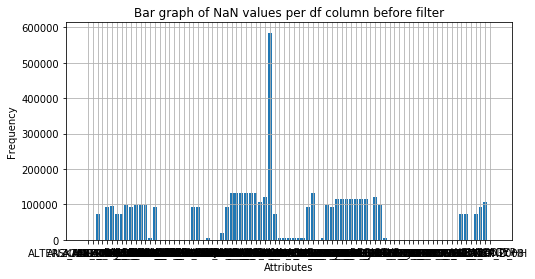

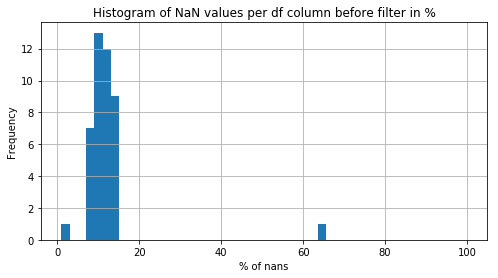

In [12]:
# Perform an assessment of how much missing data there is in each column of the
# dataset prior to the filtering

# Plotting: https://matplotlib.org/tutorials/introductory/pyplot.html

# Before eliminating new nan values
plt.figure(figsize=(8,4))

plt.bar(nan_columns_prior.index, nan_columns_prior)

plt.xlabel('Attributes')
plt.ylabel('Frequency')
plt.title('Bar graph of NaN values per df column before filter')
plt.grid(True)
plt.show()


# Before eliminating new nan values, in %
plt.figure(figsize=(8,4))
plt.hist(nan_columns_prior_percent, bins = np.linspace(1,100, 50))

plt.xlabel('% of nans')
plt.ylabel('Frequency')
plt.title('Histogram of NaN values per df column before filter in %')
plt.grid(True)
plt.show()

Before finding the rest of the nans, we can see that most of the attributes onoly have less than 20% of their items missing. With the only exepction of the one above 60%

### For Rows

We calculate the totals to get % of nans later

In [13]:
number_attributes = azdias.shape[1]

In [14]:
nan_rows_prior = azdias.isnull().sum(axis = 1)
nan_rows_prior_percent = nan_rows_prior/number_attributes * 100

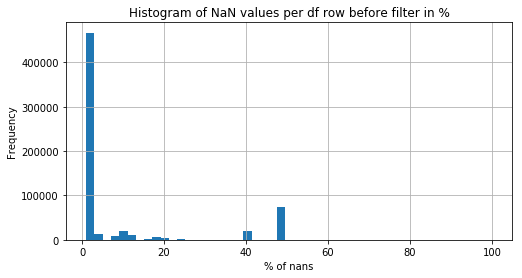

In [15]:
# Perform an assessment of how much missing data there is in each column of the
# dataset prior to the filtering

# Plotting: https://matplotlib.org/tutorials/introductory/pyplot.html

# THIS ONE TAKES TOO LONG, I CANNOT EXECUTE IT
# Before eliminating new nan values
# plt.figure(figsize=(8,4))

# plt.bar(nan_rows_prior.index, nan_rows_prior)

# plt.xlabel('Attributes')
# plt.ylabel('Frequency')
# plt.title('Bar graph of NaN values per df column before filter')
# plt.grid(True)
# plt.show()


# Before eliminating new nan values, in %
plt.figure(figsize=(8,4))
plt.hist(nan_rows_prior_percent, bins = np.linspace(1,100, 50))

plt.xlabel('% of nans')
plt.ylabel('Frequency')
plt.title('Histogram of NaN values per df row before filter in %')
plt.grid(True)
plt.show()

For the rows, we see again that the most mayority are below 21%

In [16]:
azdias.shape

(891221, 85)

In [17]:
values = []

# counter to keep up with the index of the series
counter = 0
# Iteration per colum: https://thispointer.com/pandas-loop-or-iterate-over-all-or-certain-columns-of-a-dataframe/
for (columnName, columnData) in azdias.iteritems():
    
    # REF: https://stackoverflow.com/questions/17071871/how-to-select-rows-from-a-dataframe-based-on-column-values
    missing_values_series = feat_info['missing_or_unknown'].loc[feat_info['attribute']==columnName]
    # Eliminating values from string: https://www.journaldev.com/23674/python-remove-character-from-string
    missing_values = missing_values_series[counter]
    counter += 1
    missing_values = missing_values.replace('[', '')
    missing_values = missing_values.replace(']', '')
    missing_values = missing_values.split(',')
    for missing_value in missing_values:
        values.append(missing_value)
    # We delete the '' as it is not useful: https://stackoverflow.com/questions/2793324/is-there-a-simple-way-to-delete-a-list-element-by-value
    values = [int(i) if (i != 'X' and i != 'XX' and i != '') else i for i in values] 
    
    for value in values:
        
        azdias[columnName].replace(value, np.nan, inplace=True)

    values = []


In [18]:
azdias.shape

(891221, 85)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

### For Columns

##### Answering the question: How much missing data is present in each column?

We calculate the frequency after the filter of nans

In [19]:
nan_columns = azdias.isnull().sum(axis = 0)
nan_columns_percent = nan_columns/number_rows * 100

This is after the new filtering of nans

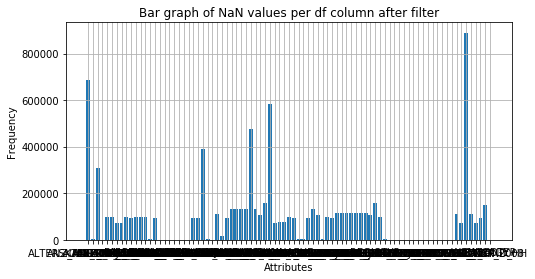

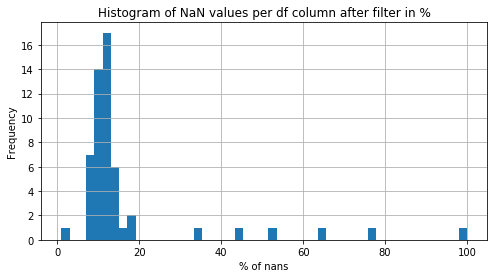

In [20]:
# Perform an assessment of how much missing data there is in each column of the
# dataset prior to the filtering

# Plotting: https://matplotlib.org/tutorials/introductory/pyplot.html

# Before eliminating new nan values
plt.figure(figsize=(8,4))

plt.bar(nan_columns.index, nan_columns)

plt.xlabel('Attributes')
plt.ylabel('Frequency')
plt.title('Bar graph of NaN values per df column after filter')
plt.grid(True)
plt.show()


# Before eliminating new nan values, in %
plt.figure(figsize=(8,4))
plt.hist(nan_columns_percent, bins = np.linspace(1,100, 50))

plt.xlabel('% of nans')
plt.ylabel('Frequency')
plt.title('Histogram of NaN values per df column after filter in %')
plt.grid(True)
plt.show()

There is a clear increase on the number of nans found after the filter in comparison with the previous histogram

Now we will select the column outliers of the missing data. For that, we will calculate the mean and the median of missing values.

In [21]:
nan_columns_percent.mean()

11.054139407027646

In [22]:
nan_columns_percent.median()

10.451728583594866

In [23]:
outliers = nan_columns_percent[nan_columns_percent > 15]
outliers

AGER_TYP          76.955435
GEBURTSJAHR       44.020282
TITEL_KZ          99.757636
ALTER_HH          34.813699
KK_KUNDENTYP      65.596749
W_KEIT_KIND_HH    16.605084
KBA05_BAUMAX      53.468668
KKK               17.735668
REGIOTYP          17.735668
dtype: float64

Looking at the table we see 3 elements with values between 16 and 18%. The rest, 6, are between 34 and 100%.
This means that there is a difference of 16%. But it is difficult to come to a conclussion to what ais an outlier. It would be easy to say that anything abot 18 is one, but I will use an ML tool to support my decision.

In [24]:
attributes_with_nan = nan_columns_percent[nan_columns_percent > 0]
attributes_with_nan.head()

AGER_TYP                76.955435
ALTERSKATEGORIE_GROB     0.323264
CJT_GESAMTTYP            0.544646
GEBURTSJAHR             44.020282
GFK_URLAUBERTYP          0.544646
dtype: float64

In [25]:
df_attributes_with_nan = pd.DataFrame(attributes_with_nan, columns=['Nan_perct'])
df_attributes_with_nan.head()

Nan_perct
AGER_TYP              76.955435
ALTERSKATEGORIE_GROB   0.323264
CJT_GESAMTTYP          0.544646
GEBURTSJAHR           44.020282
GFK_URLAUBERTYP        0.544646

In [26]:
# Because we want to differentiate between outliers and non-outliers, we make 2 groups.
# https://stackoverflow.com/questions/50113595/how-to-get-k-means-cluster-for-1d-data
k_value = 2
kmeans = KMeans(n_clusters=k_value)
df_attributes_with_nan['label'] = kmeans.fit_predict(df_attributes_with_nan[['Nan_perct']])

In [27]:
df_attributes_with_nan[df_attributes_with_nan['label'] == 1]

Nan_perct  label
AGER_TYP      76.955435      1
GEBURTSJAHR   44.020282      1
TITEL_KZ      99.757636      1
KK_KUNDENTYP  65.596749      1
KBA05_BAUMAX  53.468668      1

My human eye would consider ALTER_HH 34.813699% also an outlier, but KMeans does not. For the sake of practicing, let us check the scree plot.

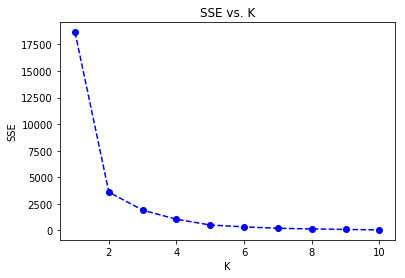

In [28]:
# Ref: frunction from the course

# A place for your work - create a scree plot - you will need to
# Fit a kmeans model with changing k from 1-10
# Obtain the score for each model (take the absolute value)
# Plot the score against k

def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

scores = []
centers = list(range(1,11))

for center in centers:
    scores.append(get_kmeans_score(df_attributes_with_nan[['Nan_perct']], center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

We must agree that the number of clusters is 2, as the largest jump is between 1 and 2.

I will however also eliminate ALTER_HH 34.813699%, as it is 16% higher than the next smaller % and the difference between the first smallers and second smallers is very little. Thus, the columns I will eliminate are:


In [29]:
outliers = nan_columns_percent[nan_columns_percent > 18]
outliers

AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
dtype: float64

Let us investigate common patterns between missing values and columns

In [30]:
missing_value_columns = nan_columns[nan_columns > 0]
len(missing_value_columns)

61

Ot of 82 attributesm there are 61 that have a missing value. Let us check the uniqueness of the amounts of missing values per column:

In [31]:
print(missing_value_columns.unique())
len(missing_value_columns.unique())

[685843   2881   4854 392318 111196  97632  94572  77792 108315 108164
  73499 889061 310267  18348 584612 147988  99611  97008  93148  73969
  99352 133324 476524  93740  93155 158064 105800 116515  97375  97274]


30

Even though there are 61 attributes with missing data, there are only 30 unique amounts of missing values, this means that some columns potentially have missing the row, or perhaps they have different rows missing, but in that case there is a symmetry. Let us investigate which attributes have the same number of missing nans.

In [32]:
df_missing_value_columns = pd.DataFrame(missing_value_columns, columns = ['NaN_freq']) 

In [33]:
group_df_missing_value_columns = df_missing_value_columns.groupby('NaN_freq')

In [34]:
missing_value_groups = {}
for key, item in group_df_missing_value_columns:
    
    if group_df_missing_value_columns.get_group(key).count()[0] > 1:
        missing_value_groups[item['NaN_freq'][0]] =  item.index

In [35]:
missing_value_groups

{4854: Index(['CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
        'RETOURTYP_BK_S', 'ONLINE_AFFINITAET'],
       dtype='object'),
 73499: Index(['SOHO_KZ', 'ANZ_PERSONEN', 'ANZ_TITEL', 'WOHNDAUER_2008'], dtype='object'),
 77792: Index(['LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB'], dtype='object'),
 93148: Index(['GEBAEUDETYP', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE'], dtype='object'),
 93740: Index(['BALLRAUM', 'EWDICHTE', 'INNENSTADT'], dtype='object'),
 97375: Index(['ARBEIT', 'RELAT_AB'], dtype='object'),
 99352: Index(['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015'], dtype='object'),
 111196: Index(['HEALTH_TYP', 'SHOPPER_TYP', 'VERS_TYP'], dtype='object'),
 116515: Index(['PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX',
        'PLZ8_HHZ', 'PLZ8_GBZ'],
       dtype='object'),
 133324: Index(['KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ',
        'MOBI_REGIO'],
       dtype='object'),
 158064: Index(

Our suspicion is that these attributes that have the same number of nan values have the same rows missing. Let us verify that.

In [36]:
missing_value_groups_same = {}

for key in missing_value_groups:
    
    index_list = []
    for attribute in missing_value_groups[key]:
       
        # Get index, ref: https://www.geeksforgeeks.org/return-the-index-label-if-some-condition-is-satisfied-over-a-column-in-pandas-dataframe/
        index_list.append(np.array(azdias[pd.isnull(azdias[attribute])].index.tolist()))
    
    # If all the index lists are the same, this means that they not only have the same amount of missing nans,
    # but also it is the same row that is missing
    boolean = True
    for i in range(1, len(index_list)):
        
        # array comparison: https://kite.com/python/answers/how-to-compare-two-numpy-arrays-in-python
        comparison = index_list[0] == index_list[i]
        equal_arrays = comparison.all()
        
        if equal_arrays == False:
            boolean = False
            break
    
    missing_value_groups_same[key] = boolean

In [37]:
missing_value_groups_same

{4854: True,
 73499: True,
 77792: True,
 93148: True,
 93740: True,
 97375: True,
 99352: True,
 111196: True,
 116515: True,
 133324: True,
 158064: True}

This is indeed interesting, not only they have the same amount of numbers missing, but also these are in the exact same rows. Let us now remove the outliers. We eliminate anything that has more than 18% of their values missing, and we consider them outliers.

In [38]:
outliers = nan_columns_percent[nan_columns_percent > 18]
outliers

AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
dtype: float64

In [39]:
azdias.shape

(891221, 85)

In [40]:
#outliersazdias = azdias.drop(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'], axis=1)
outliersazdias = azdias.drop(outliers.index, axis=1, inplace=True)

In [41]:
azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

#####  Are there any patterns in missing values?
Yes, the columns missing the same number of values also have the same values missing.
#####  Which columns were removed from the dataset?
These were the columns removed, together with their % of missing values. Reason is above: 
AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668

##### For the remaining features, are there any patterns in which columns have, or share, missing data?
This answer is equal to the first one, as removing columns will remove some attributes, but the ones remaining, if they have the same amount of nan values missing, they will also have the same exact values missing between them.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

### For rows (we do not see necessary to also check the missing values of the attributes we have deleted for the fact that they will be not part of the future analysis)

#### How much data is missing in each row of the dataset?


In [42]:
nan_rows = azdias.isnull().sum(axis = 1)
nan_rows_percent = nan_rows/number_attributes * 100

In [43]:
nan_rows_percent

0         50.588235
1          0.000000
2          0.000000
3          8.235294
4          0.000000
5          0.000000
6          0.000000
7          0.000000
8          0.000000
9          0.000000
10         0.000000
11        55.294118
12         7.058824
13         9.411765
14        55.294118
15         9.411765
16         7.058824
17        55.294118
18         3.529412
19         0.000000
20        11.764706
21         0.000000
22         0.000000
23         9.411765
24        55.294118
25         5.882353
26        22.352941
27         0.000000
28         0.000000
29         2.352941
            ...    
891191     0.000000
891192     0.000000
891193     0.000000
891194     0.000000
891195     0.000000
891196     0.000000
891197     0.000000
891198     0.000000
891199     0.000000
891200     0.000000
891201     0.000000
891202     0.000000
891203    16.470588
891204     0.000000
891205     0.000000
891206     0.000000
891207     0.000000
891208     3.529412
891209     0.000000


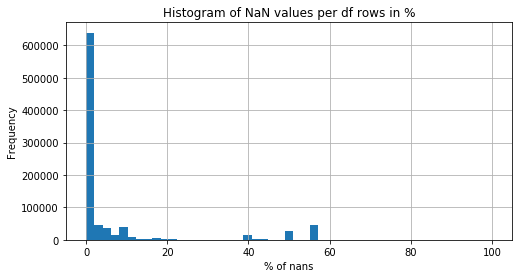

In [44]:
# Perform an assessment of how much missing data there is in each column of the
# dataset prior to the filtering

# Plotting: https://matplotlib.org/tutorials/introductory/pyplot.html

# Before eliminating new nan values, in %
plt.figure(figsize=(8,4))
plt.hist(nan_rows_percent, bins = np.linspace(0,100, 50))

plt.xlabel('% of nans')
plt.ylabel('Frequency')
plt.title('Histogram of NaN values per df rows in %')
plt.grid(True)
plt.show()

I would set the thershold at around 10%, but let us check what k_means says about my decision.

#### Write code to divide the data into two subsets based on the number of missing values in each row.

In [45]:
rows_with_nan = nan_rows_percent[nan_rows_percent > 0]
rows_with_nan.head()

0     50.588235
3      8.235294
11    55.294118
12     7.058824
13     9.411765
dtype: float64

In [46]:
df_rows_with_nan = pd.DataFrame(rows_with_nan, columns=['Nan_perct'])
df_rows_with_nan.head()

Nan_perct
0   50.588235
3    8.235294
11  55.294118
12   7.058824
13   9.411765

In [47]:
k_value = 2
kmeans = KMeans(n_clusters=k_value)
df_rows_with_nan['label'] = kmeans.fit_predict(df_rows_with_nan[['Nan_perct']])

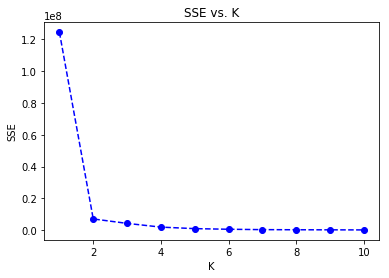

In [48]:
scores = []
centers = list(range(1,11))

for center in centers:
    scores.append(get_kmeans_score(df_rows_with_nan[['Nan_perct']], center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

This one is even more clear than before. The perfect K is 2.

In [49]:
# !!!!!!!! Careful here, it depends on the label. 
# For me it was 0, but I run it a couple of times and sometimes it is 1 for the outliers
outliers = df_rows_with_nan[df_rows_with_nan['label'] == 1]

In [50]:
# This is only done for the purpose of convinience. Because the label sometimes flips, and I know that the outliers
# have a minimum of 29... % (as I already run it), then if this condition is not met, this means that the label
# for outliers is not 1, but 0. So we have to redefine the outliers vector.
# I do this because I many times restart and run all cells, and if kmeans happens to flip the labels, then 
# there will be mistakes derived from a function later on that chooses the label for non outliers
# Of course, this would be tailored in another problem

non_outlier_index = 0
if min(outliers['Nan_perct']) < 29:
    
    outliers = df_rows_with_nan[df_rows_with_nan['label'] == 0]
    non_outlier_index = 1

print(non_outlier_index)

0


Looking at the histogram I set the threshold at above 10% they are outliers, kmenas sets it above 29 percent. I was more restrcitive.

In [51]:
rows_with_nan = nan_rows_percent[nan_rows_percent > 0]
len(rows_with_nan)

268012

In [52]:
len(rows_with_nan)/(azdias.shape[0])*100

30.07245116531141

There are 30% of rows with missing data. Let us see what is the percentage if we take the kmeans result.

In [53]:
rows_with_nan = nan_rows_percent[nan_rows_percent >= 29.411764705882355]
len(rows_with_nan)

93315

In [54]:
len(rows_with_nan)/(azdias.shape[0])*100

10.470466921223805

If we follow what k means says, we have 10% of the rows that are outliers, it is a reasonable number given the experience I have from the course. Let us check with my estimation of outliers having more than 10% of missing data.

In [55]:
rows_with_nan = nan_rows_percent[nan_rows_percent >= 10]
len(rows_with_nan)

119520

In [56]:
len(rows_with_nan)/(azdias.shape[0])*100

13.410815050363489

Given the jump from 29% to 10% of 19% in number of misisng values, and only 3.4% more in the rows included as outliers, this time, I will consider the 2 groups made by kmeans more suitable for distingusing outliers than my own prior intuition. Thus, I will later delete the outliers which have more than 29% of their rows missing.

In [57]:
azdias['label'] = df_rows_with_nan['label'] 

Columns with a label of NaN have 0 missing values. Columns with 0 have few missing values and columns with 1 have a lot of missing vaues (outliers)

In [58]:
nan_rows_percent.values

array([ 50.58823529,   0.        ,   0.        , ...,   5.88235294,
         0.        ,   0.        ])

#### Compare the distribution of values for at least five columns where there are no or few missing values, between the two subsets.
This is done to check if there are rows in the dataset that are qualitatively different and happen also to belong to rows that have more missing data. So we are looking for a correlation between the nature of data and the missing values.

We would first need to find 5 columns where there are not too many missing values in both subsets, the ones with nan or 0 and the ones with 1. Once we make two distinc groups (the subgroups), we compare 5 columns with not too many missing data on each subset. So, to select the 5 with not so many missing values, we will use the subset of outliers, because this is the critical subset. The same columns (or any set of columns) on the other subset will not have too many missing values because they have inherentily this property as we define the subset with that premise.

In [59]:
# We first mix the rows with few missing values with the rows with no missing values at all.
# Here we have the same issue with the label, it depends on KMEANS. 0 is the label for those who had few values
# in my run, thus, the ones that are null (menaing that they have no missing values), should be 0 if we want
# to combine their group with the group with few missing values
azdias.loc[azdias['label'].isnull(), 'label'] = non_outlier_index

In [60]:
df_temp = azdias
low_nan_azdias_subset = df_temp[df_temp['label'] == 0] 
low_nan_azdias_subset = low_nan_azdias_subset.drop(['label'], axis=1)
high_nan_azdias_subset = df_temp[df_temp['label'] == 1] 
high_nan_azdias_subset = high_nan_azdias_subset.drop(['label'], axis=1)
;

''

In [61]:
low_nan_azdias_subset.shape

(797906, 79)

In [62]:
high_nan_azdias_subset.shape

(93315, 79)

If we see that qualitatively they are not the same, perhaps it is a good idea to make the subsets more equal in size.
Now we choose 5 columns with low amount of missing numbers in the subset with high overall number of nans.

In [63]:
high_nan_azdias_subset.isnull().sum()

ALTERSKATEGORIE_GROB        81
ANREDE_KZ                    0
CJT_GESAMTTYP              176
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_VORSORGER             0
FINANZ_ANLEGER               0
FINANZ_UNAUFFAELLIGER        0
FINANZ_HAUSBAUER             0
FINANZTYP                    0
GFK_URLAUBERTYP            176
GREEN_AVANTGARDE             0
HEALTH_TYP               74525
LP_LEBENSPHASE_FEIN      47554
LP_LEBENSPHASE_GROB      47377
LP_FAMILIE_FEIN          46444
LP_FAMILIE_GROB          46444
LP_STATUS_FEIN             176
LP_STATUS_GROB             176
NATIONALITAET_KZ         74444
PRAEGENDE_JUGENDJAHRE    79467
RETOURTYP_BK_S             176
SEMIO_SOZ                    0
SEMIO_FAM                    0
SEMIO_REL                    0
SEMIO_MAT                    0
SEMIO_VERT                   0
SEMIO_LUST                   0
SEMIO_ERL                    0
SEMIO_KULT                   0
                         ...  
MIN_GEBAEUDEJAHR         93148
OST_WEST

Let us choose FINANZ_MINIMALIST, FINANZ_ANLEGER, which have no missing data, and ALTERSKATEGORIE_GROB, GFK_URLAUBERTYP, and LP_STATUS_GROB which do not have too many.

In [64]:
attribute_list = ['FINANZ_MINIMALIST', 'FINANZ_ANLEGER', 'ALTERSKATEGORIE_GROB', 'GFK_URLAUBERTYP', 'LP_STATUS_GROB']


In [65]:
for attribute in attribute_list:
    print(low_nan_azdias_subset[attribute].unique())

[1 4 3 2 5]
[5 2 1 4 3]
[  1.   3.   4.   2.  nan]
[ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan]
[  1.   2.   4.   5.   3.  nan]


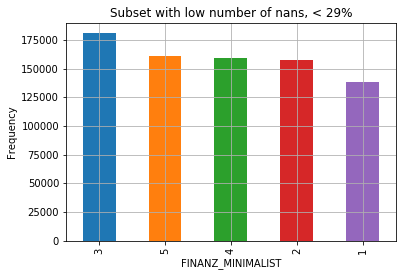

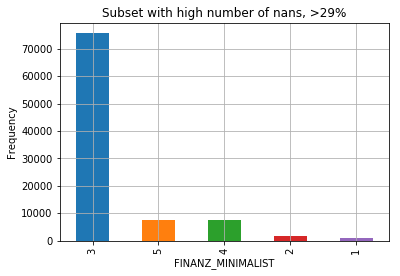

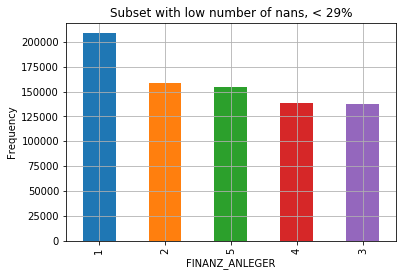

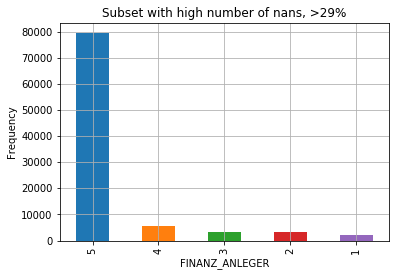

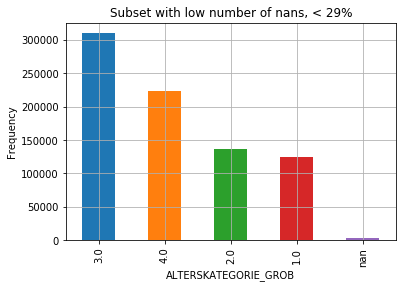

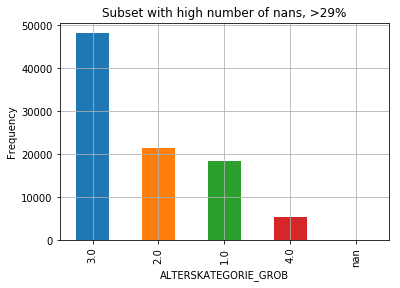

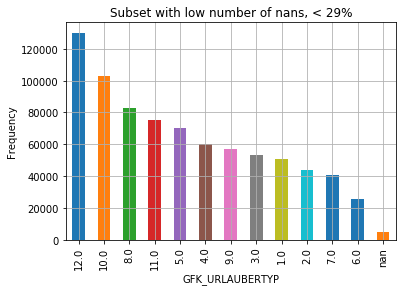

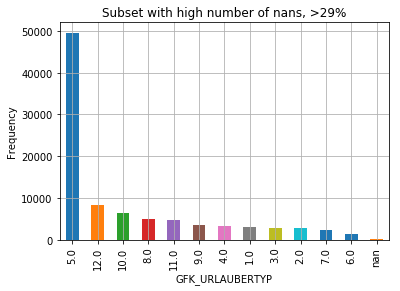

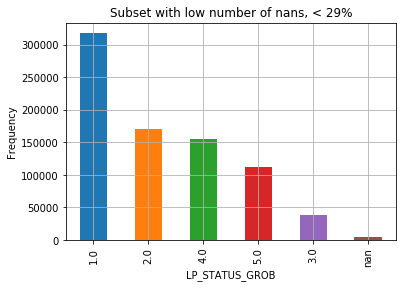

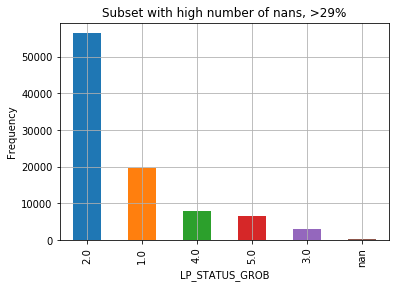

In [66]:
# plotting ref: https://kite.com/python/answers/how-to-plot-two-matplotlib-plots-side-by-side-in-python
# cpounting also nans in a histogram/bar plot, ref: https://stackoverflow.com/questions/32239093/python-pandas-histogram-plot-including-nan-values

for attribute in attribute_list:
    counts = low_nan_azdias_subset[attribute].value_counts(dropna=False)

    plt.figure(figsize=(13,4))
    plt.subplot(1, 2, 1)
    plt.xlabel(attribute)
    plt.ylabel('Frequency')
    plt.grid(True)

    counts.plot.bar(title='Subset with low number of nans, < 29%', grid=True)
    
    counts = high_nan_azdias_subset[attribute].value_counts(dropna=False)

    plt.figure(figsize=(13,4))
    plt.subplot(1, 2, 2)
    plt.xlabel(attribute)
    plt.ylabel('Frequency')
    plt.grid(True)
       
    counts.plot.bar(title='Subset with high number of nans, >29%', grid=True)

    plt.show()


Now we delete the rows that are outliers wirth respect to the number of nan values.

In [67]:
rows_with_nan_above_29 = nan_rows_percent[nan_rows_percent >= 29.411764705882355]
print('Number of rows with nans above 29% of their values:', len(rows_with_nan_above_29))
print('% of the rows with nans above 29% of their values:', len(rows_with_nan_above_29)/(azdias.shape[0])*100)
print('We will thus eliminate 10.47% of the rows, following the index in rows_with_nan_above_29')

Number of rows with nans above 29% of their values: 93315
% of the rows with nans above 29% of their values: 10.470466921223805
We will thus eliminate 10.47% of the rows, following the index in rows_with_nan_above_29


In [68]:
outlier_rows = rows_with_nan_above_29.index.tolist()
len(outlier_rows)

93315

In [69]:
azdias.drop(columns=['label'], axis=1, inplace=True)

In [70]:
azdias.shape

(891221, 79)

In [71]:
azdias.drop(azdias.index[[outlier_rows]], inplace=True)

In [73]:
azdias.shape

(797906, 79)

In [74]:
# Let us check that the percentage of rows eliminated is the same as the % of rows which were outliers
100-(azdias.shape[0]/891221*100)

10.470466921223803

Indeed we succeeded. 

#### Discussion 1.1.3: Assess Missing Data in Each Row

##### Are the data with lots of missing values qualitatively different from data with few or no missing values?)

There are differences in all of them, and big ones. 

The conlcusion is that they are qualitatively different, which is very interesting. A group with more values missing, are qualitatively different from a group with lower number of missing data. There is a relationship between missing data and the type of people behind the data.

Note that we have deleted the outlier rows, around 10% of the initial row amount.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [75]:
feat_info.head()

attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical             [-1,0]
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]
3         CJT_GESAMTTYP            person  categorical                [0]
4     FINANZ_MINIMALIST            person      ordinal               [-1]

In [76]:
feat_info.type.unique()

array(['categorical', 'ordinal', 'numeric', 'mixed', 'interval'], dtype=object)

Numeric, interval, ordinal -> Remain the same
categorial, mixed -> further pre-processing (keep, re-encode, drop)

#### How many features are there of each data type?

In [77]:
feat_info.type.value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [78]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
groups_feat_info = feat_info.groupby('type')

In [79]:
for key, item in groups_feat_info:
    
    if key == 'categorical':
        
        categorical_group = np.array(item['attribute'])
        
    if key == "mixed":
        
        mixed_group = np.array(item['attribute'])
        
    else:
        
        continue

In [80]:
df_cat = pd.DataFrame(categorical_group, columns=['attribute'])


In [81]:
import math

def find_cat_type(azdias, attribute):

    if attribute in azdias.columns:
        
        # drop nans from array: https://stackoverflow.com/questions/11620914/removing-nan-values-from-an-array
        x = azdias[attribute].unique()

        # I have to do this step first because otherwise the code would give an error trying to do x = x[~np.isnan(x)]
        for unique in x:
            
            if unique == 'O' or unique == 'W':

                return 'binary_character'
            
            elif type(unique) == str:

                return 'multi_cat_numerical'
                
        x = x[~np.isnan(x)]
        
        if len(x)> 2:

            # no need to check for characters as tthe exercise says that only binary attributes could have characters
            return 'multi_cat_numerical'
        
        else:

            return 'binary_numerical'
        
    else:
        # This would mean the attribute was deleted in the main dataframe
        return np.nan

df_cat['cat_type'] = df_cat.apply(lambda row: find_cat_type(azdias, row['attribute']), axis=1)
    

In [82]:
df_cat

attribute             cat_type
0           AGER_TYP                  NaN
1          ANREDE_KZ     binary_numerical
2      CJT_GESAMTTYP  multi_cat_numerical
3          FINANZTYP  multi_cat_numerical
4    GFK_URLAUBERTYP  multi_cat_numerical
5   GREEN_AVANTGARDE     binary_numerical
6    LP_FAMILIE_FEIN  multi_cat_numerical
7    LP_FAMILIE_GROB  multi_cat_numerical
8     LP_STATUS_FEIN  multi_cat_numerical
9     LP_STATUS_GROB  multi_cat_numerical
10  NATIONALITAET_KZ  multi_cat_numerical
11       SHOPPER_TYP  multi_cat_numerical
12           SOHO_KZ     binary_numerical
13          TITEL_KZ                  NaN
14          VERS_TYP     binary_numerical
15          ZABEOTYP  multi_cat_numerical
16      KK_KUNDENTYP                  NaN
17       GEBAEUDETYP  multi_cat_numerical
18       OST_WEST_KZ     binary_character
19   CAMEO_DEUG_2015  multi_cat_numerical
20    CAMEO_DEU_2015  multi_cat_numerical

We will now encode the only binary character into 'O'=0 and 'W'=1 in the main dataframe

In [83]:
azdias.shape

(797906, 79)

In [84]:
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].apply(lambda row: 1 if row == 'W' else row)
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].apply(lambda row: 0 if row == 'O' else row)

In [85]:
# We check
azdias['OST_WEST_KZ'].unique()

array([1, 0])

For the attributes with multi-variables, we perform on-hot encoding.

In [86]:
# Re-encode categorical variable(s) to be kept in the analysis.



In [87]:
# We check
azdias['CJT_GESAMTTYP'].unique()

array([  5.,   3.,   2.,   4.,   1.,   6.,  nan])

In [88]:
azdias.shape

(797906, 79)

In [89]:
for index, row in df_cat.iterrows():
    
    if row['cat_type'] == 'multi_cat_numerical':
        
        attribute = row['attribute']
        # one hot encoding, ref: https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python
        one_hot = pd.get_dummies(azdias[attribute], prefix=attribute)
        # Drop column as it is now encoded
        azdias = azdias.drop(attribute, axis = 1)
        # Join the encoded df
        azdias = azdias.join(one_hot)


In [90]:
# We check if we have new attributes
azdias.shape

(797906, 194)

In [91]:
# And we check that there is a new encoded column
azdias['CJT_GESAMTTYP_1.0'].unique()

array([0, 1], dtype=uint64)

#### Discussion 1.2.1: Re-Encode Categorical Features

##### Which ones did you keep, which did you drop, and what engineering steps did you perform?)

I made a list of the the categorical and mixed values. Within the categorical, I divided them into binary_numeric, binary_character, and multi categorical. I re-encoded the binary_character one and hot-encoded the multi_categhorical type. I did not drop any attribute.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [92]:
mixed_group

array(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015',
       'KBA05_BAUMAX', 'PLZ8_BAUMAX'], dtype=object)

##### PRAEGENDE_JUGENDJAHRE

In [93]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias["PRAEGENDE_JUGENDJAHRE"].unique()

array([ 14.,  15.,   8.,   3.,  10.,  11.,   5.,   9.,   6.,   4.,  nan,
         2.,   1.,  12.,  13.,   7.])

In [94]:
def classify_decade(row):
    
    if row == 1 or row == 2: 
            return 1; 
    elif row == 3 or row == 4: 
            return 2; 
    elif row == 5 or row == 6 or row == 7: 
        return 3; 
    elif row == 8 or row == 9: 
        return 4; 
    elif row == 10 or row == 11 or row == 12 or row == 13: 
        return 5; 
    elif row == 14 or row == 15: 
        return 6; 
    else: 
        return np.nan; 

def classify_movement(row):
    
    if row == 1 or row == 3 or row == 5 or row == 8 or row == 10 or row == 12 or row == 14: 
        return 1; 
    elif row == 2 or row == 4 or row == 6 or row == 7 or row == 9 or row == 11 or row == 13 or row == 15: 
        return 2; 
    else: 
        return np.nan; 

azdias["PRAEGENDE_JUGENDJAHRE_decade"] = azdias["PRAEGENDE_JUGENDJAHRE"].apply(lambda row: classify_decade(row))
azdias["PRAEGENDE_JUGENDJAHRE_movement"] = azdias["PRAEGENDE_JUGENDJAHRE"].apply(lambda row: classify_movement(row))


We make a check

In [95]:
azdias["PRAEGENDE_JUGENDJAHRE_decade"].head()

1    6.0
2    6.0
3    4.0
4    4.0
5    2.0
Name: PRAEGENDE_JUGENDJAHRE_decade, dtype: float64

In [96]:
azdias["PRAEGENDE_JUGENDJAHRE_movement"].head()

1    1.0
2    2.0
3    1.0
4    1.0
5    1.0
Name: PRAEGENDE_JUGENDJAHRE_movement, dtype: float64

##### CAMEO_INTL_2015

In [97]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias["CAMEO_INTL_2015"].unique()

array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41',
       '34', '55', nan, '25', '23', '31', '52', '35', '45', '44', '32'], dtype=object)

In [98]:
# We assume the wealth and liestage correspond to the tens-place and the ones-place respectovely, in that order,
# as it was described in the exercise
azdias["CAMEO_INTL_2015_Wealth"] = azdias["CAMEO_INTL_2015"].apply(lambda row: round(int(row) / 10) if not pd.isna(row) else np.nan)
azdias["CAMEO_INTL_2015_Life_Stage"] = azdias["CAMEO_INTL_2015"].apply(lambda row: int(row) % 10 if not pd.isna(row) else np.nan)

We make some checks

In [99]:
azdias["CAMEO_INTL_2015"].head()

1    51
2    24
3    12
4    43
5    54
Name: CAMEO_INTL_2015, dtype: object

In [100]:
azdias["CAMEO_INTL_2015_Wealth"].head()

1    5.0
2    2.0
3    1.0
4    4.0
5    5.0
Name: CAMEO_INTL_2015_Wealth, dtype: float64

In [101]:
azdias["CAMEO_INTL_2015_Life_Stage"].head()

1    1.0
2    4.0
3    2.0
4    3.0
5    4.0
Name: CAMEO_INTL_2015_Life_Stage, dtype: float64

Now we drop all the columns that are no longer necessary

In [102]:
azdias = azdias.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1)
azdias = azdias.drop(['CAMEO_INTL_2015'], axis=1)

Let us explore other attributes

In [103]:
mixed_group

array(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015',
       'KBA05_BAUMAX', 'PLZ8_BAUMAX'], dtype=object)

In [104]:
# There is however one attribute which was previously deleted 
'KBA05_BAUMAX' in azdias.columns

False

In [105]:
# Life stage, fine scale
print('LP_LEBENSPHASE_FEIN', azdias['LP_LEBENSPHASE_FEIN'].unique())
# Social status, rough scale
print('LP_LEBENSPHASE_GROB', azdias['LP_LEBENSPHASE_GROB'].unique())
print('WOHNLAGE', azdias['WOHNLAGE'].unique())
print('PLZ8_BAUMAX', azdias['PLZ8_BAUMAX'].unique())

LP_LEBENSPHASE_FEIN [ 21.   3.  nan  32.   8.   2.   5.  10.   4.   6.  23.  12.  20.   1.  11.
  25.  13.  18.  31.  38.  35.  30.   7.  22.  14.  29.  24.  28.  37.  26.
  39.  27.  36.   9.  34.  33.  15.  40.  16.  19.  17.]
LP_LEBENSPHASE_GROB [  6.   1.  nan  10.   2.   3.   5.   7.  12.  11.   9.   4.   8.]
WOHNLAGE [ 4.  2.  7.  3.  5.  1.  8.  0.]
PLZ8_BAUMAX [  1.   2.  nan   4.   5.   3.]


Summary:
LP_LEBENSPHASE_FEIN(very granular, and there is no need to encode because each value means soemthing),
LP_LEBENSPHASE_GROB(very granular, and there is no need to encode because each value means soemthing),
This information is already in CAMEO_INTL_2015. Also, LP_LEBENSPHASE_GROB is contained in LP_LEBENSPHASE_FEIN.
We

WOHNLAGE(There is no need to encode because each value means somehting. Unique information with respect to the rest) 
PLZ8_BAUMAX(There is no need to encode because each value means soemthing. Unique information with respect to the rest)

We keep the last two for their unique information.
We discard LP_LEBENSPHASE_GROB because it is repeated in LP_LEBENSPHASE_FEIN and in CAMEO_INTL_2015.
We keep LP_LEBENSPHASE_FEIN because it is more granular than CAMEO_INTL_2015.

In [106]:
azdias = azdias.drop(['LP_LEBENSPHASE_GROB'], axis=1)

### Discussion 1.2.2: Engineer Mixed-Type Features

##### Which ones did you keep, which did you drop, and what engineering steps did you perform? Reasons above.

#####  We re-encoded PRAEGENDE_JUGENDJAHRE, CAMEO_INTL_2015
In one value they held multiple insights, thus it is necessary to re-encode them.

We have dropped KBA05_BAUMAX (already dropped before), LP_LEBENSPHASE_GROB (repeated information in LP_LEBENSPHASE_FEIN and in CAMEO_INTL_2015)


 We kept the same WOHNLAGE, PLZ8_BAUMAX, LP_LEBENSPHASE_FEIN


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

#### If there are other re-engineering tasks you need to perform, make sure you take care of them here. (Dealing with missing data will come in step 2.1.)

In each previous step we deleted the not necessary columns due to re-engineering, or too many missing values.

However now we must check whether we have the correct types and taht there is nothing unexpectzed.

In [107]:
# ref: https://numpy.org/doc/stable/reference/generated/numpy.unique.html
np.unique(azdias.dtypes.values)

array([dtype('uint8'), dtype('int64'), dtype('float64')], dtype=object)

In [108]:
# We check that we have more columns
azdias.shape

(797906, 195)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

Before doing the function, let us compare the 2 dataframes. And it seems they do have the same columns, thus, we will perform the same steps as before into the function below without a problem.

In [109]:
azdias_original = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')
azdias_original.head()

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                      4                 5    ...            2.0         3.0   
2                      3                 5    ...            3.0         3.0   
3                      1                 2    ...            2.0         2.0   
4                      3                 2    ...            2.0         4.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   
2         1.0         0.0          1.0       4.0       4.0     3.0   
3         2.0         0.0          1.0       3.0       4.0     2.0   
4         2.0         1.0          2.0       3.0       3.0     4.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  
2          5.0       2.0  
3          3.0       3.0  
4          6.0       5.0  

[5 rows x 85 columns]

In [110]:
df = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')
df.head()

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0         2                     4          1            5.0   
1        -1                     4          1            NaN   
2        -1                     4          2            2.0   
3         1                     4          1            2.0   
4        -1                     3          1            6.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  5              1                 5               1   
1                  5              1                 5               1   
2                  5              1                 5               1   
3                  5              1                 5               2   
4                  3              1                 4               4   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      2                 2    ...            3.0         3.0   
1                      3                 2    ...            NaN         NaN   
2                      4                 4    ...            2.0         3.0   
3                      1                 2    ...            3.0         2.0   
4                      5                 2    ...            2.0         4.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         1.0         0.0          1.0       5.0       5.0     1.0   
1         NaN         NaN          NaN       NaN       NaN     NaN   
2         3.0         1.0          3.0       3.0       2.0     3.0   
3         1.0         0.0          1.0       3.0       4.0     1.0   
4         2.0         1.0          2.0       3.0       3.0     3.0   

   ORTSGR_KLS9  RELAT_AB  
0          2.0       1.0  
1          NaN       NaN  
2          5.0       3.0  
3          3.0       1.0  
4          5.0       1.0  

[5 rows x 85 columns]

In [111]:
# For them to have the same columns, this expression must be FALSE
False in (np.unique(azdias_original.columns) == np.unique(df.columns))

False

In [112]:
# We included for readbility, some more inputs to indicate the rows and columns that must be deleted
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')
    
    total_rows = df.shape[0]
    number_attributes = df.shape[1]
    print('beforevaalues', df.shape)
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    values = []

    # counter to keep up with the index of the series
    counter = 0
    # Iteration per colum: https://thispointer.com/pandas-loop-or-iterate-over-all-or-certain-columns-of-a-dataframe/
    for (columnName, columnData) in df.iteritems():

        # REF: https://stackoverflow.com/questions/17071871/how-to-select-rows-from-a-dataframe-based-on-column-values
        missing_values_series = feat_info['missing_or_unknown'].loc[feat_info['attribute']==columnName]
        # Eliminating values from string: https://www.journaldev.com/23674/python-remove-character-from-string
        missing_values = missing_values_series[counter]
        counter += 1
        missing_values = missing_values.replace('[', '')
        missing_values = missing_values.replace(']', '')
        missing_values = missing_values.split(',')
        for missing_value in missing_values:
            values.append(missing_value)
        # We delete the '' as it is not useful: https://stackoverflow.com/questions/2793324/is-there-a-simple-way-to-delete-a-list-element-by-value
        values = [int(i) if (i != 'X' and i != 'XX' and i != '') else i for i in values] 

        for value in values:
            
            df[columnName].replace(value, np.nan, inplace=True)
        
        values = []
    print('afetrvalues', df.shape)
    
    # This however will not be done this way as it causes a large amount of columns to be deleted
    # Deleting columns that are outliers for this particular dataset. We use also 18% as the threshold
#     nan_columns = df.isnull().sum(axis = 0)
#     nan_columns_percent = nan_columns/total_rows * 100
    
#     outliers_columns = nan_columns_percent[nan_columns_percent > 18]
#     print('beforecolumn', df.shape)
    #df.drop(outliers_columns.index, axis=1, inplace=True)
    df.drop(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'], axis=1, inplace=True)
    print('aftercolum', df.shape)
    
    # Deleting a set of outlier rows (We could use Kmeans as before, but using the same % (29) for outliers, will leave
    # the same type of rows (in terms of nans) in both datasets, which will make them more comparable.
    
    nan_rows = df.isnull().sum(axis = 1)
    nan_rows_percent = nan_rows/number_attributes * 100
    
    rows_with_nan_above_29 = nan_rows_percent[nan_rows_percent >= 29.411764705882355]
    outlier_rows = rows_with_nan_above_29.index.tolist()
    print('BEFORErow', df.shape)
    df.drop(df.index[[outlier_rows]], inplace=True)
    print('afterrow', df.shape)
    print('We deleted this % of rows:', 100-(df.shape[0]/total_rows*100))
    
    # One-hot encoding
    groups_feat_info = feat_info.groupby('type')
    for key, item in groups_feat_info:

        if key == 'categorical':

            categorical_group = np.array(item['attribute'])

        if key == "mixed":

            mixed_group = np.array(item['attribute'])

        else:

            continue
            
    df_cat = pd.DataFrame(categorical_group, columns=['attribute'])
    df_cat['cat_type'] = df_cat.apply(lambda row: find_cat_type(df, row['attribute']), axis=1)
    
    print('BEFORE1', df.shape)
    # select, re-encode, and engineer column values.
    if 'OST_WEST_KZ' in df.columns:
        
        df['OST_WEST_KZ'] = df['OST_WEST_KZ'].apply(lambda row: 1 if row == 'W' else row)
        df['OST_WEST_KZ'] = df['OST_WEST_KZ'].apply(lambda row: 0 if row == 'O' else row)
    
    print('before', df.shape)
    for index, row in df_cat.iterrows():
    
        if row['cat_type'] == 'multi_cat_numerical':

            attribute = row['attribute']
            # one hot encoding, ref: https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python
            one_hot = pd.get_dummies(df[attribute], prefix=attribute)
            # Drop column as it is now encoded
            df = df.drop(attribute, axis = 1)
            # Join the encoded df
            df = df.join(one_hot)
    print('after', df.shape)
    
    if 'PRAEGENDE_JUGENDJAHRE' in df.columns:
        # Dealing with the multi categorical values
        df["PRAEGENDE_JUGENDJAHRE_decade"] = df["PRAEGENDE_JUGENDJAHRE"].apply(lambda row: classify_decade(row))
        df["PRAEGENDE_JUGENDJAHRE_movement"] = df["PRAEGENDE_JUGENDJAHRE"].apply(lambda row: classify_movement(row))
        df = df.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1)
    
    if 'CAMEO_INTL_2015' in df.columns:
        df["CAMEO_INTL_2015_Wealth"] = df["CAMEO_INTL_2015"].apply(lambda row: round(int(row) / 10) if not pd.isna(row) else np.nan)
        df["CAMEO_INTL_2015_Life_Stage"] = df["CAMEO_INTL_2015"].apply(lambda row: int(row) % 10 if not pd.isna(row) else np.nan)
        df = df.drop(['CAMEO_INTL_2015'], axis=1)
    
    if 'LP_LEBENSPHASE_GROB' in df.columns:
        df = df.drop(['LP_LEBENSPHASE_GROB'], axis=1)
 
    # Return the cleaned dataframe.
    return df, outlier_rows
    

Testing the function

In [113]:
azdias_fresh = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

In [114]:
azdias_fresh_clean, outlier_rows_test = clean_data(azdias_fresh)

beforevaalues (891221, 85)
afetrvalues (891221, 85)
aftercolum (891221, 79)
BEFORErow (891221, 79)
afterrow (797906, 79)
We deleted this % of rows: 10.470466921223803
BEFORE1 (797906, 79)
before (797906, 79)
after (797906, 194)


They should have the same values.

In [115]:
azdias_fresh_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797906 entries, 1 to 891220
Columns: 195 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_Life_Stage
dtypes: float64(44), int64(23), uint8(128)
memory usage: 531.4 MB


In [116]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797906 entries, 1 to 891220
Columns: 195 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_Life_Stage
dtypes: float64(44), int64(23), uint8(128)
memory usage: 531.4 MB


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [117]:
#If you've not yet cleaned the dataset of all NaN values, then investigate and do that now.


In [118]:
azdias.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                   1.0          2                  1              5   
2                   3.0          2                  1              4   
3                   4.0          2                  4              2   
4                   3.0          1                  4              3   
5                   1.0          2                  3              1   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1                 2               5                      4                 5   
2                 1               2                      3                 5   
3                 5               2                      1                 2   
4                 4               1                      3                 2   
5                 5               2                      2                 5   

   GREEN_AVANTGARDE  HEALTH_TYP             ...              \
1                 0         3.0             ...               
2                 1         3.0             ...               
3                 0         2.0             ...               
4                 0         3.0             ...               
5                 0         3.0             ...               

   CAMEO_DEU_2015_8D  CAMEO_DEU_2015_9A  CAMEO_DEU_2015_9B  CAMEO_DEU_2015_9C  \
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   
5                  0                  0                  0                  0   

   CAMEO_DEU_2015_9D  CAMEO_DEU_2015_9E  PRAEGENDE_JUGENDJAHRE_decade  \
1                  0                  0                           6.0   
2                  0                  0                           6.0   
3                  0                  0                           4.0   
4                  0                  0                           4.0   
5                  0                  0                           2.0   

   PRAEGENDE_JUGENDJAHRE_movement  CAMEO_INTL_2015_Wealth  \
1                             1.0                     5.0   
2                             2.0                     2.0   
3                             1.0                     1.0   
4                             1.0                     4.0   
5                             1.0                     5.0   

   CAMEO_INTL_2015_Life_Stage  
1                         1.0  
2                         4.0  
3                         2.0  
4                         3.0  
5                         4.0  

[5 rows x 195 columns]

In [119]:
# imputer to dataframe ref:https://stackoverflow.com/questions/33660836/impute-entire-dataframe-all-columns-using-scikit-learn-sklearn-without-itera
# We use the median because the average might be not representative of the 
# column if there are some outliers with big weights (skewed)
fill_NaN = Imputer(missing_values=np.nan, strategy='mean', axis=1)
imputed_azdias = pd.DataFrame(fill_NaN.fit_transform(azdias))
imputed_azdias.columns = azdias.columns
imputed_azdias.index = azdias.index

In [120]:
imputed_azdias.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                   1.0        2.0                1.0            5.0   
2                   3.0        2.0                1.0            4.0   
3                   4.0        2.0                4.0            2.0   
4                   3.0        1.0                4.0            3.0   
5                   1.0        2.0                3.0            1.0   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1               2.0             5.0                    4.0               5.0   
2               1.0             2.0                    3.0               5.0   
3               5.0             2.0                    1.0               2.0   
4               4.0             1.0                    3.0               2.0   
5               5.0             2.0                    2.0               5.0   

   GREEN_AVANTGARDE  HEALTH_TYP             ...              \
1               0.0         3.0             ...               
2               1.0         3.0             ...               
3               0.0         2.0             ...               
4               0.0         3.0             ...               
5               0.0         3.0             ...               

   CAMEO_DEU_2015_8D  CAMEO_DEU_2015_9A  CAMEO_DEU_2015_9B  CAMEO_DEU_2015_9C  \
1                0.0                0.0                0.0                0.0   
2                0.0                0.0                0.0                0.0   
3                0.0                0.0                0.0                0.0   
4                0.0                0.0                0.0                0.0   
5                0.0                0.0                0.0                0.0   

   CAMEO_DEU_2015_9D  CAMEO_DEU_2015_9E  PRAEGENDE_JUGENDJAHRE_decade  \
1                0.0                0.0                           6.0   
2                0.0                0.0                           6.0   
3                0.0                0.0                           4.0   
4                0.0                0.0                           4.0   
5                0.0                0.0                           2.0   

   PRAEGENDE_JUGENDJAHRE_movement  CAMEO_INTL_2015_Wealth  \
1                             1.0                     5.0   
2                             2.0                     2.0   
3                             1.0                     1.0   
4                             1.0                     4.0   
5                             1.0                     5.0   

   CAMEO_INTL_2015_Life_Stage  
1                         1.0  
2                         4.0  
3                         2.0  
4                         3.0  
5                         4.0  

[5 rows x 195 columns]

We check that it worked. Index 0 of HEALTH_TYP in the original one is NaN and in the imputed dataset is a number.

In [121]:
# Apply feature scaling to the general population demographics data.


In [122]:
scaler = preprocessing.StandardScaler()
imputed_azdias_ss = scaler.fit_transform(imputed_azdias) # Fit and transform the data
imputed_azdias_ss = pd.DataFrame(imputed_azdias_ss) #create a dataframe
imputed_azdias_ss.columns = imputed_azdias.columns #add column names again

In [123]:
imputed_azdias_ss.describe()

ALTERSKATEGORIE_GROB     ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
count          7.979060e+05  7.979060e+05       7.979060e+05   7.979060e+05   
mean          -7.419724e-17 -1.320091e-16       4.790940e-18  -1.296849e-16   
std            1.000001e+00  1.000001e+00       1.000001e+00   1.000001e+00   
min           -1.474025e+00 -1.043916e+00      -1.494563e+00  -1.155483e+00   
25%           -6.719531e-01 -1.043916e+00      -7.686419e-01  -1.155483e+00   
50%            1.301188e-01  9.579316e-01      -4.272067e-02   1.912375e-01   
75%            9.321907e-01  9.579316e-01       6.832005e-01   8.645978e-01   
max            1.613376e+01  9.579316e-01       1.409122e+00   1.537958e+00   

       FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
count      7.979060e+05    7.979060e+05           7.979060e+05   
mean      -4.193408e-17    8.629035e-17           3.943175e-17   
std        1.000001e+00    1.000001e+00           1.000001e+00   
min       -1.766947e+00   -1.249970e+00          -1.184817e+00   
25%       -1.040677e+00   -1.249970e+00          -1.184817e+00   
50%        4.118625e-01    1.080290e-01          -4.702601e-01   
75%        1.138132e+00    7.870286e-01           9.588546e-01   
max        1.138132e+00    1.466028e+00           1.673412e+00   

       FINANZ_HAUSBAUER  GREEN_AVANTGARDE    HEALTH_TYP  \
count      7.979060e+05      7.979060e+05  7.979060e+05   
mean       8.335167e-18      8.157065e-18 -9.837457e-17   
std        1.000001e+00      1.000001e+00  1.000001e+00   
min       -1.501658e+00     -5.304424e-01 -6.438410e-01   
25%       -7.914458e-01     -5.304424e-01 -2.815065e-01   
50%       -8.123363e-02     -5.304424e-01 -2.815065e-01   
75%        6.289785e-01     -5.304424e-01  8.082798e-02   
max        1.339191e+00      1.885219e+00  7.787781e+00   

                  ...              CAMEO_DEU_2015_8D  CAMEO_DEU_2015_9A  \
count             ...                   7.979060e+05       7.979060e+05   
mean              ...                  -2.201339e-17       1.009838e-17   
std               ...                   1.000001e+00       1.000001e+00   
min               ...                  -1.500793e-01      -1.625583e-01   
25%               ...                  -1.500793e-01      -1.625583e-01   
50%               ...                  -1.500793e-01      -1.625583e-01   
75%               ...                  -1.500793e-01      -1.625583e-01   
max               ...                   6.663143e+00       6.151639e+00   

       CAMEO_DEU_2015_9B  CAMEO_DEU_2015_9C  CAMEO_DEU_2015_9D  \
count       7.979060e+05       7.979060e+05       7.979060e+05   
mean        6.084850e-17      -6.379609e-17      -3.306461e-17   
std         1.000001e+00       1.000001e+00       1.000001e+00   
min        -1.895577e-01      -1.798002e-01      -1.927873e-01   
25%        -1.895577e-01      -1.798002e-01      -1.927873e-01   
50%        -1.895577e-01      -1.798002e-01      -1.927873e-01   
75%        -1.895577e-01      -1.798002e-01      -1.927873e-01   
max         5.275438e+00       5.561730e+00       5.187065e+00   

       CAMEO_DEU_2015_9E  PRAEGENDE_JUGENDJAHRE_decade  \
count       7.979060e+05                  7.979060e+05   
mean       -6.768761e-17                  7.627390e-16   
std         1.000001e+00                  1.000001e+00   
min        -8.976543e-02                 -1.523094e+00   
25%        -8.976543e-02                 -7.011646e-01   
50%        -8.976543e-02                  1.207649e-01   
75%        -8.976543e-02                  5.317296e-01   
max         1.114015e+01                  8.276132e+00   

       PRAEGENDE_JUGENDJAHRE_movement  CAMEO_INTL_2015_Wealth  \
count                    7.979060e+05            7.979060e+05   
mean                    -2.709464e-16           -4.349604e-16   
std                      1.000001e+00            1.000001e+00   
min                     -2.774213e-01           -1.386873e+00   
25%                     -2.774213e-01           -

In [124]:
azdias = imputed_azdias_ss

We check and indeed the means are about 0 and the std is 1.

Now we make a checkpoint and keep using the name Azdias.

### Discussion 2.1: Apply Feature Scaling

Removing all data points (rows) with missing data would incur in a lot of information loss. We have already deleted tghe rows with an excessive amount of missing values, thus, the remaining rows have more menaingful data than not, thus, eliminating every row with a nan would mean to lose too much information for not so many nan values.

Imputer is a better option. It will replace the nan with the mean, median or mode of the values of that attribute. By using imputer, we do not need to delete the rows with nans, and thus, we keep the information.

Reference to scale data with mean 0 and std of 1:
https://stats.stackexchange.com/questions/46429/transform-data-to-desired-mean-and-standard-deviation

Given the procedure to scale, it does not matter if you add new values to an array, you will nonetheless achieve a distribution with mean 0 and standard deviation of 1. Thus, it does not matter, to the best of my knowledge, that you use the imputer before or after. Therefore, we use the imputer before the scaling as it is programmatically simpler.
The amount of missing values does not matter. Perhaps on computation time, but it is not an issue.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [125]:
# Apply PCA to the data.
pca = PCA()
azdias_pca = pca.fit_transform(azdias)


In [126]:
# This is the number of components
len(pca.components_)

195

In [127]:
# We should get 1 because we have one component per feature
ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
ratios.sum()

1.0

In [128]:
# Ref: Course
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

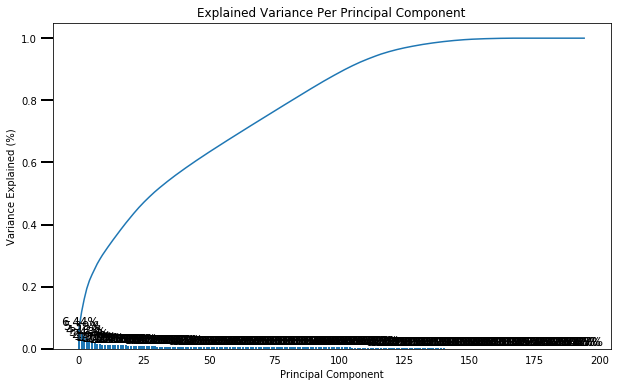

In [129]:
scree_plot(pca)

In [130]:
vals = pca.explained_variance_ratio_

As in the course, we will use a threhold of 85% of the variance explained to select the representative PComponenets.

In [131]:
cum_variance = 0
index = 0
for ind, val in enumerate(vals):
    
    if cum_variance < 0.85:
        cum_variance += val
        index = ind
    else:
        break

In [132]:
# We print the index of the variable at which the cumulative variance first exceeds 85% of the explained variance
print(index, cum_variance)

92 0.85193238808


The index is 92, so we stop at the 93rd component. So let us do the pca again for 93 components.
We reduced the components by almost 50%.

In [133]:
# Re-apply PCA to the data while selecting for number of components to retain. One more component than the index because the index of
# the previous loop starts at 0, but this object PCA does not
pca_final = PCA(93)
azdias_pca = pca_final.fit_transform(azdias)

In [134]:
azdias_pca.shape

(797906, 93)

In [135]:
# We should get around 0.85
ratios = pca_final.explained_variance_ratio_.reshape(len(pca_final.components_), 1)
ratios.sum()

0.84912120237768129

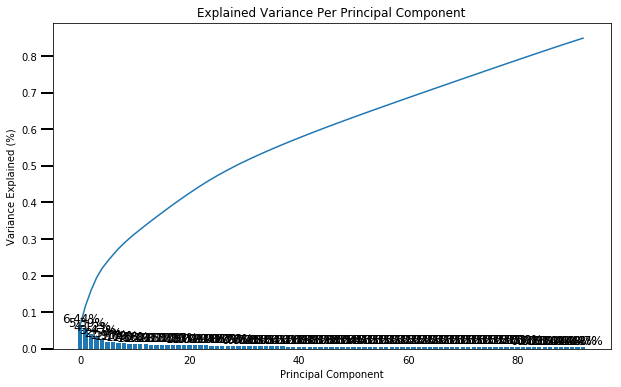

In [136]:
scree_plot(pca_final)

In [137]:
column_names_pca = []

for i in range(1,94):
    
    column_names_pca.append('PC_{}'.format(i))

Checkpoints

In [138]:
pk.dump(pca_final, open("pca_final.pkl","wb"))
pca_final = pk.load(open("pca_final.pkl",'rb'))

In [139]:
# pk.dump(azdias_pca, open('azdias_pca.pkl', 'wb'))
# azdias_pca = pk.load(open("azdias_pca.pkl",'rb'))

azdias_pca_Df = pd.DataFrame(data = azdias_pca, columns = column_names_pca)
azdias_pca_Df.to_pickle("azdias_pca_Df.pkl")
azdias_pca_Df = pd.read_pickle("azdias_pca_Df.pkl")

In [140]:
# azdias.to_pickle("azdiasV6.pkl")
# azdias = pd.read_pickle("azdiasV6.pkl")

### Discussion 2.2: Perform Dimensionality Reduction

We first performed PCA with all the components, to see the variability explained by each. However, this would defeat the purpose of PCA, we need to find the few components that explain most of the variability. A good number is 85%, so we will perform PCA with the components that explain 85% of the variability.
How many principal components / transformed features are you retaining for the next step of the analysis?)
The number to explain 85% of the variability is.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [141]:
def pca_results(full_dataset, pca, ith_component):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    #dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    #fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    #components.plot(ax = ax, kind = 'bar');
    #ax.set_ylabel("Feature Weights")
    #ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    #for i, ev in enumerate(pca.explained_variance_ratio_):
    #    ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1).iloc[ith_component]

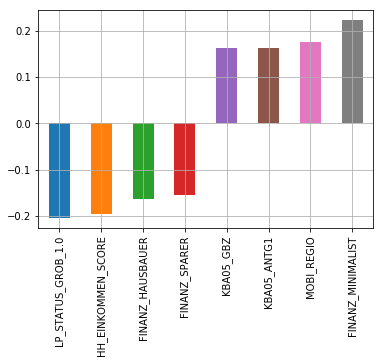

In [142]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
first_PC = pca_results(azdias, pca_final, 0)
first_PC_top_weights = pd.concat([first_PC.sort_values().head(4), first_PC.sort_values().tail(4)])
first_PC_top_weights.plot.bar(grid=True)
plt.show()


FINANZ_MINIMALIST: Financial typology. low financial interest             
KBA05_GBZ: Number of buildings in the microcell (from 1 to many)                     
KBA05_ANTG1: Number of 1-2 family houses in the microcell (from 1 to many)                    
MOBI_REGIO: Movement patterns (from a lot to less)                    

The first PC positively correlates the financial interest, home related features and how often the person travels.
       
Vs. 

LP_STATUS_GROB_1: Social status, rough scale. low income earners. 
HH_EINKOMMEN_SCORE: Estimated household net income. (from 1 hight to 6 low)
FINANZ_SPARER:  Financial typology. money-saver                  
FINANZ_HAUSBAUER: Financial typology. home ownership   


The first PC negativeley correlates the social status, with the income and whether the person is a money saver or owns a house. 

These two sets are inversely correlated.

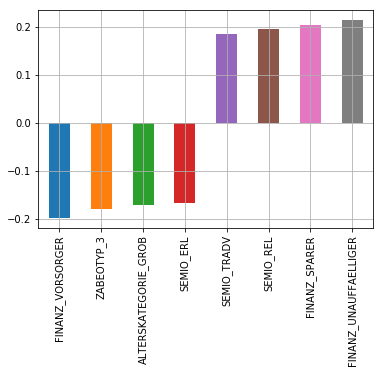

In [143]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
second_PC = pca_results(azdias, pca_final, 1)
second_PC_top_weights = pd.concat([second_PC.sort_values().head(4), second_PC.sort_values().tail(4)])
second_PC_top_weights.plot.bar(grid=True)
plt.show()

SEMIO_TRADV: Personality typology, for each dimension. tradional-minded.                    
SEMIO_REL: Personality typology, religious.                  
FINANZ_SPARER:  money-saver                   
FINANZ_UNAUFFAELLIGER: Financial typology. inconspicuous        

The second PC positively correlates the personality typology revolving around religion and cult culture, and whether the person is a money saver and whether the person is inconspicuous in spending money.

Vs.

FINANZ_VORSORGER: Financial typology. be prepared               
ZABEOTYP_3: Energy consumption typology. fair supplied                     
SEMIO_ERL: Personality typology, event-oriented. 


The second PC negativeley correlates financial typology to be ready for the unexpected, energy consumption in the moderate category, and whether the person has an event oriented mindset or not.

These two sets are inversely correlated.


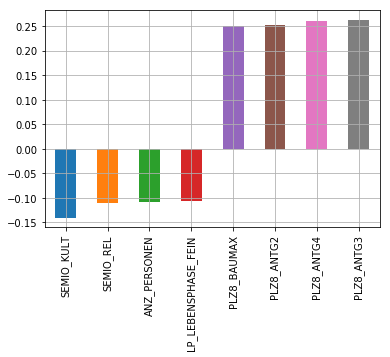

In [144]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
third_PC = pca_results(azdias, pca_final, 2)
third_PC_top_weights = pd.concat([third_PC.sort_values().head(4), third_PC.sort_values().tail(4)])
third_PC_top_weights.plot.bar(grid=True)
plt.show()

PLZ8_ANTG2:  Number of 3-5 family houses in the PLZ8 region.  From low to high.             
PLZ8_ANTG4: Number of 10+ family houses in the PLZ8 region. (from 1 low share to 2 high share)               
PLZ8_BAUMAX: Most common building type within the PLZ8 region. (from 1 low number of family homes, to larger number and business buildings)               
PLZ8_ANTG3: Number of 6-10 family houses in the PLZ8 region. (from low to high share)

The third PC positively correlates then number of family houses and the type of buildings. So overall, this PC is about homes.

Vs.

SEMIO_KULT: Personality typology, cultural-minded              
LP_LEBENSPHASE_FEIN: Life stage, from single low-income earners of younger age to top earners at retirement age from multiperson households.      
ANZ_PERSONEN: Number of adults in household             

The third PC negatively correlates a personality type of cultural mindedness, the life stage, the number of adults in the household. So this one is more about people.

This PC correlates informaiton inveresely between building and human information.

### Discussion 2.3: Interpret Principal Components

The explained relations are below the graphs for convinience.

#### Can we interpret positive and negative values from them in a meaningful way?
Yes.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [145]:
# Ref: frunction from the course, modified to get the average score

# A place for your work - create a scree plot - you will need to
# Fit a kmeans model with changing k from 1-10
# Obtain the score for each model (take the absolute value)
# Plot the score against k

def get_kmeans_average_distance(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # compute the average within-cluster distances.
    score = np.abs(model.score(data))/data.shape[0]
    
    return score

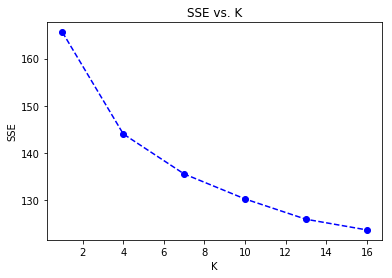

In [146]:
scores = []
# from 1 to 16 with jumps of 3
centers = list(range(1,17,3))

for center in centers:
    scores.append(get_kmeans_average_distance(azdias_pca, center))

# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

It took incredibly long to compute, we will take 13 clusters as it seems that it is reasonable, and there is less improvements afterwards. There is potentially room for improvement, but the computation time is incredibly long. This might be because we have many features even with the PCA. 

In [147]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=13)
k_model = kmeans.fit(azdias_pca)
k_prediction_demographics = k_model.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

We went through different number of clusters to find out which one had the best score given the scree plot (biggest delta). With this number of clusters, we mak the final prediction.

Into how many clusters have you decided to segment the population?

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [148]:
# Load in the customer demographics data.
customers_df_fresh = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')
customers_df_fresh.head()

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0         2                     4          1            5.0   
1        -1                     4          1            NaN   
2        -1                     4          2            2.0   
3         1                     4          1            2.0   
4        -1                     3          1            6.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  5              1                 5               1   
1                  5              1                 5               1   
2                  5              1                 5               1   
3                  5              1                 5               2   
4                  3              1                 4               4   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      2                 2    ...            3.0         3.0   
1                      3                 2    ...            NaN         NaN   
2                      4                 4    ...            2.0         3.0   
3                      1                 2    ...            3.0         2.0   
4                      5                 2    ...            2.0         4.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         1.0         0.0          1.0       5.0       5.0     1.0   
1         NaN         NaN          NaN       NaN       NaN     NaN   
2         3.0         1.0          3.0       3.0       2.0     3.0   
3         1.0         0.0          1.0       3.0       4.0     1.0   
4         2.0         1.0          2.0       3.0       3.0     3.0   

   ORTSGR_KLS9  RELAT_AB  
0          2.0       1.0  
1          NaN       NaN  
2          5.0       3.0  
3          3.0       1.0  
4          5.0       1.0  

[5 rows x 85 columns]

In [149]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Preprocessing
customers_df, outlier_rows_customers = clean_data(customers_df_fresh)


beforevaalues (191652, 85)
afetrvalues (191652, 85)
aftercolum (191652, 79)
BEFORErow (191652, 79)
afterrow (141701, 79)
We deleted this % of rows: 26.063385719950745
BEFORE1 (141701, 79)
before (141701, 79)
after (141701, 193)


In [150]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141701 entries, 0 to 191651
Columns: 194 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_Life_Stage
dtypes: float64(44), int64(23), uint8(127)
memory usage: 95.7 MB


In [151]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797906 entries, 0 to 797905
Columns: 195 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_Life_Stage
dtypes: float64(195)
memory usage: 1.2 GB


In [152]:
# We have to see which columns of the demographic data are not in the customer data and add them empty. 
# Otherwise we can not use the pca model from before due to the shape difference
# ref: https://stackoverflow.com/questions/45482755/compare-headers-of-dataframes-in-pandas
azdias.columns.difference(customers_df.columns)

Index(['GEBAEUDETYP_5.0'], dtype='object')

In [153]:
customers_df.columns.difference(azdias.columns)

Index([], dtype='object')

list(There is a column in azdias (GEBAUEDETYP_5) which is not in the new dataframe. This means that the column GEBAUEDETYP from the customer datatset does not have a 5, so when we did one hot encoding, it did not create that column. So what we will do is add an empty column with the title GEBAEUDETYP_5.0 in the customer data set clean data with all 0s.

In [154]:
customers_df['GEBAEUDETYP_5.0'] = 0

In [155]:
customers_df.shape

(141701, 195)

In [156]:
# feature scaling
fill_NaN = Imputer(missing_values=np.nan, strategy='mean', axis=1)
imputed_customers = pd.DataFrame(fill_NaN.fit_transform(customers_df))
imputed_customers.columns = customers_df.columns
imputed_customers.index = customers_df.index

imputed_customers_ss = scaler.transform(imputed_customers) # transform the data
imputed_customers_ss = pd.DataFrame(imputed_customers_ss) #create a dataframe
imputed_customers_ss.columns = imputed_customers_ss.columns #add column names again


In [157]:
# pca
customer_pca = pca_final.transform(imputed_customers_ss)


In [158]:
customer_pca.shape

(141701, 93)

In [159]:
# Clustering
k_prediction_customer = k_model.predict(customer_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

This is done as a checkpoint to not re-execute all the cells until here.

In [160]:
#pk.dump(k_prediction_demographics, open('k_prediction_demographics.pkl', 'wb'))
k_prediction_demographics = pk.load(open("k_prediction_demographics.pkl",'rb'))
#pk.dump(k_prediction_customer, open('k_prediction_customer.pkl', 'wb'))
k_prediction_customer = pk.load(open("k_prediction_customer.pkl",'rb'))

In [161]:
#outlier_rows_demographics = outlier_rows
#pk.dump(outlier_rows_demographics, open('outlier_rows_demographics.pkl', 'wb'))
outlier_rows_demographics = pk.load(open("outlier_rows_demographics.pkl",'rb'))

In [162]:
#pk.dump(outlier_rows_customers, open('outlier_rows_customers.pkl', 'wb'))
outlier_rows_customers = pk.load(open("outlier_rows_customers.pkl",'rb'))

In [163]:
#pk.dump(scaler, open('scaler.pkl', 'wb'))
scaler = pk.load(open("scaler.pkl",'rb'))

In [164]:
#pk.dump(k_model, open('k_model.pkl', 'wb'))
k_model = pk.load(open("k_model.pkl",'rb'))

In [165]:
#pk.dump(imputed_azdias_ss, open('imputed_azdias_ss.pkl', 'wb'))
imputed_azdias_ss = pk.load(open("imputed_azdias_ss.pkl",'rb'))

#### I deleted the rows that were outliers. But I will fecth them again. I need to refactor the code. So these cluster will be just attched to the ones I have down below, we need to remember the index of those rows.
Now we calculate the number of people in the outlier rows, we add their number to the total in the customers and in the demograohics and we add the cluster in the cluster objects.

In [166]:
num_outliers_demographics = len(outlier_rows_demographics)
num_outliers_customers = len(outlier_rows_customers)

In [167]:
array_outliers_demographics = np.full((num_outliers_demographics ), -1)
array_outliers_customerss = np.full((num_outliers_customers ), -1)

In [168]:
# Amount of people in the population
num_people_demographics = len(k_prediction_demographics) + num_outliers_demographics

In [169]:
# Amount of people in the customer base
num_people_customers = len(k_prediction_customer) + num_outliers_customers

In [170]:
k_prediction_demographics_df = pd.DataFrame(k_prediction_demographics, columns=['Cluster_demographics'])
outlier_demographics_df = pd.DataFrame(array_outliers_demographics, columns=['Cluster_demographics'])
k_prediction_customer_df = pd.DataFrame(k_prediction_customer, columns=['Cluster_customer'])
outlier_customer_df = pd.DataFrame(array_outliers_customerss, columns=['Cluster_customer'])

In [171]:
k_prediction_demographics_df = pd.concat([k_prediction_demographics_df, outlier_demographics_df])
k_prediction_customer_df = pd.concat([k_prediction_customer_df, outlier_customer_df])


/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


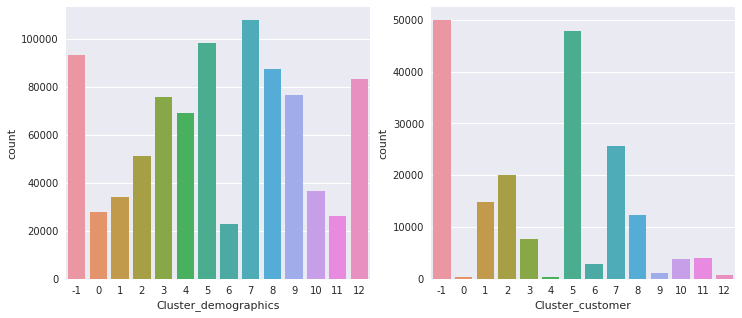

In [172]:
sns.set(style="darkgrid")

# REF: https://stackoverflow.com/questions/41659188/how-to-adjust-subplot-size-in-seaborn
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.countplot(x='Cluster_demographics', data=k_prediction_demographics_df, ax=ax[0])
sns.countplot(x='Cluster_customer', data=k_prediction_customer_df, ax=ax[1])
fig.show()

This however is difficult to compare, becuase there is no proportion between them. We need to find the relative proportions for each cluster set.

#### Important, the cluster -1 will be shifted to position 0 in the next plots, and every other cluster will be also shifted to the right 1 position

In [173]:
k_prediction_demographics_groups = k_prediction_demographics_df.groupby('Cluster_demographics')
k_prediction_customer_groups = k_prediction_customer_df.groupby('Cluster_customer')

In [174]:
demographics_number_people_per_cluster = []
customer_number_people_per_cluster = []

for key, value in k_prediction_demographics_groups:
    
    demographics_number_people_per_cluster.append(len(k_prediction_demographics_groups.get_group(key)))

for key, value in k_prediction_customer_groups:
    
    customer_number_people_per_cluster.append(len(k_prediction_customer_groups.get_group(key)))

In [175]:
demographics_percent = np.array(demographics_number_people_per_cluster)/num_people_demographics
customers_percent = np.array(customer_number_people_per_cluster)/num_people_customers

In [176]:
demographics_percent_df = pd.DataFrame(demographics_percent, columns=['Percentage'])
customers_percent_df = pd.DataFrame(customers_percent, columns=['Percentage'])

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


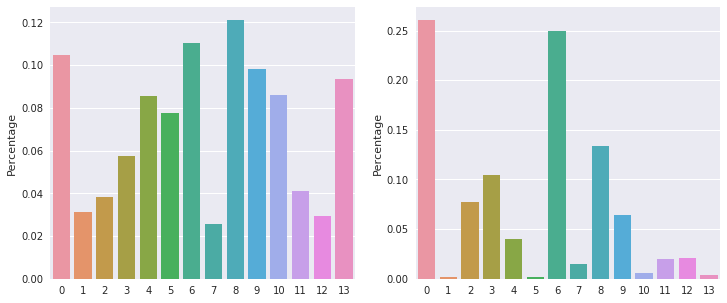

In [177]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.barplot(x=demographics_percent_df.index, y='Percentage', data=demographics_percent_df, ax=ax[0])
sns.barplot(x=customers_percent_df.index, y='Percentage', data=customers_percent_df, ax=ax[1])
fig.show()

Now we are going to make the ratios plot, the bigget the numbers above one, the more this cluster should be considered as potential target group for the business. The lowe the number below 0, the less attention the business should pay that cluster.

In [178]:
ratios_df = pd.DataFrame(customers_percent_df / demographics_percent_df)
ratios_df.columns = ['Ratio']

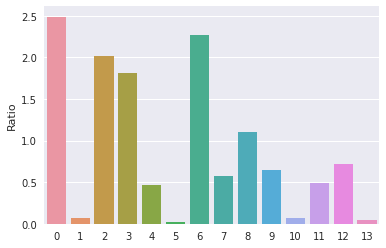

In [179]:
ax = sns.barplot(x=ratios_df.index, y="Ratio", data=ratios_df)

Anything above 1 is overrepresented in the customer data. Looking in the ratio graph, this means cluster 0 (the outlier rows, the highest), cluester, 6, 2, 3 and 8 in this order.
On the other hand, in the order of not representative clusters, we have: cluster 5, 13, 10, 1, 4, 11, 7, 9, and 12.

#### What kinds of people are part of a cluster that is overrepresented in the customer data compared to the general population?

We will pick cluster  6 from the ratio table (from the k cluster object it is cluster 5 and from the group object is also number 5). I want to avoid picking the cluster with outlier rows as that might indicate a lack of interest on business engagement (if some of the data was collected via polls)

1. We identify the most interesting components of this particular cluster which will be different to the main population.

In [180]:
# We first get the group that we are interested in. This comes from a dataframe made form the original labels of 
# of the clustering. We extract the index of the particular rows(people) with a label of 5.
target_group_index = k_prediction_demographics_groups.get_group(5).index

In [181]:
# With the indexes, we identifies the people who belong to this cluster among the general population 
# (in the demographics dataset). So now we could apply this whole notebook again, but to save time, 
# we use the standardized version of the azdias dataset to save time.
target_group_df = imputed_azdias_ss.iloc[target_group_index]

And now we do the PCA analysis again (with the same amount of features) to the target group. This will yield the particular interesting features for this cluster. We only need to fit it.

In [182]:
pca_target_group = PCA(93)

In [183]:
pca_target_group = pca_target_group.fit(target_group_df)

We now find out what are the representative features that we should look into for this particular cluster.

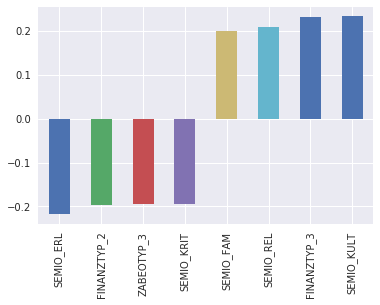

In [184]:
first_PC = pca_results(target_group_df, pca_target_group, 0)
first_PC_top_weights = pd.concat([first_PC.sort_values().head(4), first_PC.sort_values().tail(4)])
first_PC_top_weights.plot.bar(grid=True)
plt.show()

SEMIO_REL: personality type religious                      
FINANZTYP_3: home ownership (HAUSBAUER).                
SEMIO_KULT: personality typology, for each dimension (from 1 high to low affinity)                      

This are positively correlated. This means that there is a correlation with the features related to religion and cult culture, and owning a house or not.

Vs

SEMIO_ERL: event-oriented personality                     
FINANZTYP_2: money-saver (SPARER)                   
ZABEOTYP_3:  Energy consumption typology fair supplied.                   
     
These are negatively correlated. This means that there is a correlation with the features related to having an event oriented personality or not, that you might be saving money (or not), and that you might be consuming a fair supply of energy or not.


This 2 groups of features are inversely correlated.



###### Note, this very much reminds me of the second PC for the general population!!!! 

2. We know which features we will look into (the most interesting ones), now we need to plot the values within these features for the required cluster and thus study what kind of people are in this target group. By using this new PCs  we will have more specific information about this target group, rather than using the main PCs from the entire population.

In [185]:
# From the transformed data of the demograhics population, we select the rows that correspond 
# to our interesting cluster (target group). Getting in turn the transformed pca for the interesting cluster. 
cluster_pca = azdias_pca[target_group_index]

In [186]:
# now we inverse the pca and scaler transformation to go back to the origincal data.
# However, the values are altered from what I can see. So we round them 
inverted_cluster = np.round(scaler.inverse_transform(pca_final.inverse_transform(cluster_pca)))

In [187]:
# We conver the array in a dataframe so it is easier for me to plot it with seaborn
inverted_cluster_df = pd.DataFrame(inverted_cluster, columns=azdias.columns)

Now we can plot the interesting fetures and come to a conclusion. We will also plot the best PC from the entire population to see what this feature would be for this particular cluster (Are they FINANZ_MINIMALIST?).

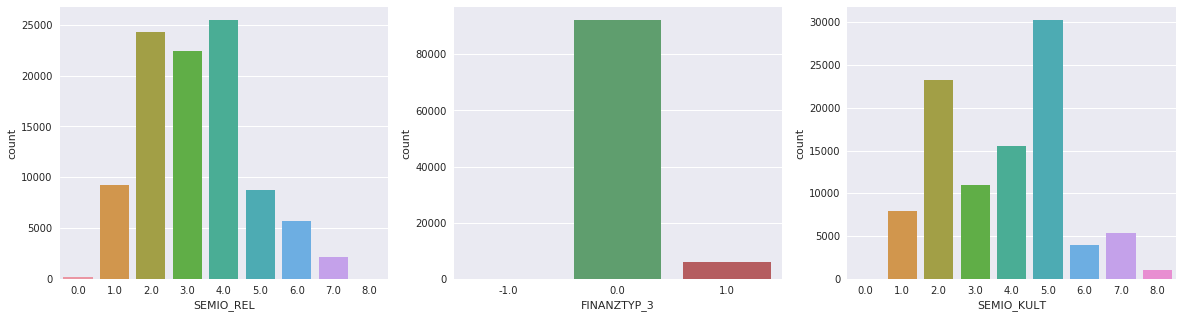

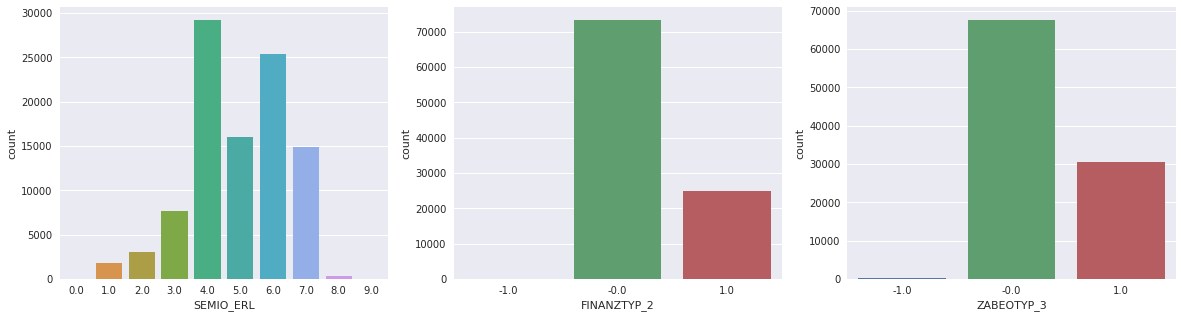

In [188]:
# multiple plots ref: https://stackoverflow.com/questions/38082602/plotting-multiple-different-plots-in-one-figure-using-seaborn/38091681
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

sns.countplot(inverted_cluster_df['SEMIO_REL'], ax=ax[0])

sns.countplot(inverted_cluster_df['FINANZTYP_3'], ax=ax[1])

sns.countplot(inverted_cluster_df['SEMIO_KULT'], ax=ax[2])

fig, ax = plt.subplots(ncols=3, figsize=(20,5))

sns.countplot(inverted_cluster_df['SEMIO_ERL'], ax=ax[0])

sns.countplot(inverted_cluster_df['FINANZTYP_2'], ax=ax[1])

sns.countplot(inverted_cluster_df['ZABEOTYP_3'], ax=ax[2])


This is ho our target group looks like:
SEMIO_REL: In general, our group has an average affinity towards religion.                   
FINANZTYP_3: Most do not own a house.                 
SEMIO_KULT: There is considerable amount of people that have a cult mindset. 
SEMIO_ERL: The average people that we have also an event oriented personality in average                   
FINANZTYP_2: They do not save money                 
ZABEOTYP_3:  They do not consume energy in a fair amount. 

We can say that our target group are usually average religious people with an average cult mindset that do not own a house. They also have an average event oriented mindset, do not save money and do not consume energy in a fair amount, it would be either higher or lower.

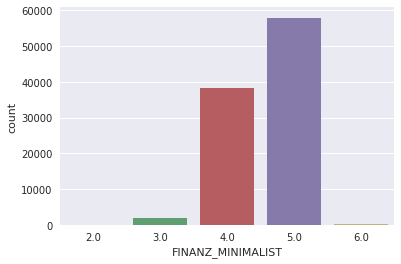

In [189]:
sns.countplot(inverted_cluster_df['FINANZ_MINIMALIST'])

5 is a low score for financial minimalist, low affinity. Thus, they are not in this financial type.

#### What kinds of people are part of a cluster that is underrepresented in the customer data compared to the general population?

I will take cluster number 5 (from the ratio table, from the k cluster object it is cluster 4 as well as group four in the cluster dataframe)

We will follow the same steps as in the previos section.

In [190]:
target_group_index = k_prediction_demographics_groups.get_group(4).index

In [191]:
target_group_df = imputed_azdias_ss.iloc[target_group_index]

And now we do the PCA analysis again (with the same amount of features) to the target group. This will yield the particular interesting features for this cluster. We only need to fit it.

In [192]:
pca_target_group = PCA(93)

In [193]:
pca_target_group = pca_target_group.fit(target_group_df)

We now find out what are the representative features that we should look into for this particular cluster.

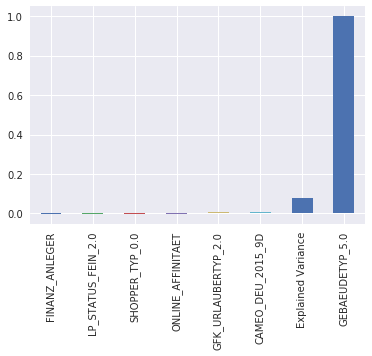

In [194]:
first_PC = pca_results(target_group_df, pca_target_group, 0)
first_PC_top_weights = pd.concat([first_PC.sort_values().head(4), first_PC.sort_values().tail(4)])
first_PC_top_weights.plot.bar(grid=True)
plt.show()

GEBAEUDETYP_5.0: this is basically the important feature, but this is the column we added to the datset afterwards.               
It makes sense tha is the one with least representation. Let us choose the second smallest then, cluster number 13 in the ratio graph and number 12 in the cluster groups



In [195]:

target_group_index = k_prediction_demographics_groups.get_group(12).index

In [196]:

target_group_df = imputed_azdias_ss.iloc[target_group_index]

And now we do the PCA analysis again (with the same amount of features) to the target group. This will yield the particular interesting features for this cluster. We only need to fit it.

In [197]:
pca_target_group = PCA(93)

In [198]:
pca_target_group = pca_target_group.fit(target_group_df)

We now find out what are the representative features that we should look into for this particular cluster.

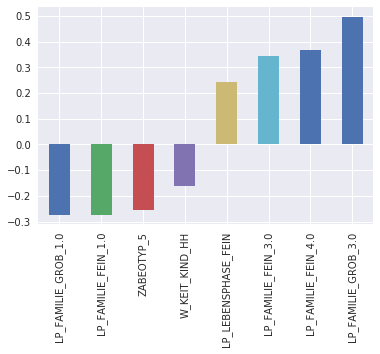

In [199]:
first_PC = pca_results(target_group_df, pca_target_group, 0)
first_PC_top_weights = pd.concat([first_PC.sort_values().head(4), first_PC.sort_values().tail(4)])
first_PC_top_weights.plot.bar(grid=True)
plt.show()

LP_FAMILIE_FEIN_3.0: Family type, fine scale. young single parent           
LP_FAMILIE_FEIN_4.0: Family type, fine scale. single parent with teenager           
LP_FAMILIE_GROB_3.0: Family type, single parent (maps to 3-5 in fine scale)          

This are positively correlated. This group makes sense as they are all about isngle parenting. These revolved around the family type.

Vs.

LP_FAMILIE_GROB_1.0: family type. single (maps to 1 in fine scale)          
LP_FAMILIE_FEIN_1.0: family type. single
ZABEOTYP_5: energy consumption, seeking orientation        

These are negatively correlated. It makes sense because they are about being single without kids (2 of the features). And there is also a correlation with  a feature about seeking orientation in energy consumption.


This 2 groups of features are inversely correlated. It makes sense (saying that single means that you had no relationship that prodiuced a child vs single in the context that you are the only one taking care of the child), if you are a single parent, then you are not single, you had a relationship.


2. We know which features we will look into (the most interesting ones), now we need to plot the values within these features for the required cluster and thus study what kind of people are in this target group. By using this new PCs  we will have more specific information about this target group, rather than using the main PCs from the entire population.

In [200]:
# From the transformed data of the demograhics population, we select the rows that correspond 
# to our interesting cluster (target group). Getting in turn the transformed pca for the interesting cluster. 
cluster_pca = azdias_pca[target_group_index]

In [201]:
# now we inverse the pca and scaler transformation to go back to the origincal data.
# However, the values are altered from what I can see. So we round them 
inverted_cluster = np.round(scaler.inverse_transform(pca_final.inverse_transform(cluster_pca)))

In [202]:
# We conver the array in a dataframe so it is easier for me to plot it with seaborn
inverted_cluster_df = pd.DataFrame(inverted_cluster, columns=azdias.columns)

Now we can plot the interesting fetures and come to a conclusion. We will also plot the best PC from the entire population to see what this feature would be for this particular cluster (Are they FINANZ_MINIMALIST?).

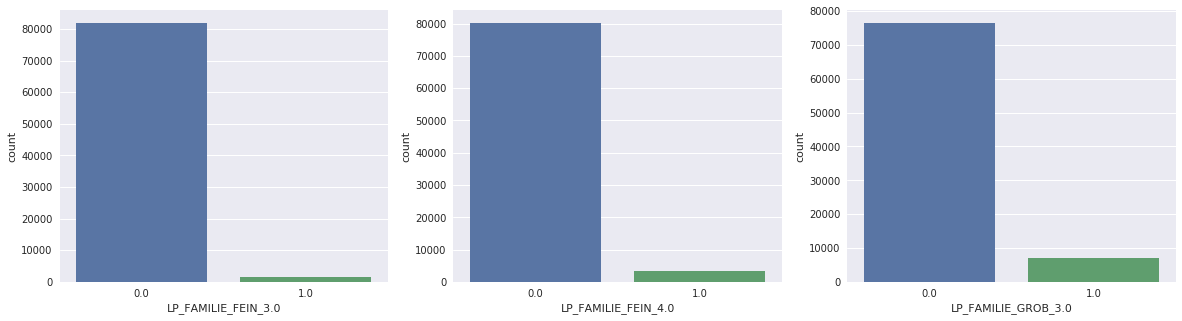

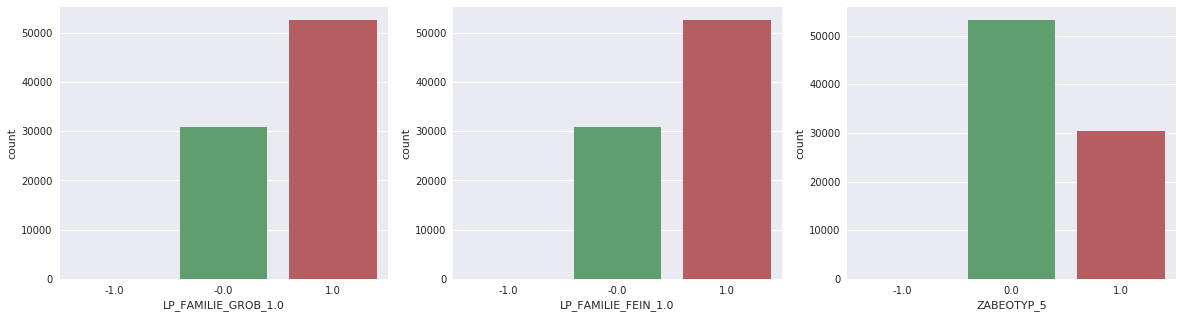

In [203]:
# Invert tick labels ref: https://stackoverflow.com/questions/26540035/rotate-label-text-in-seaborn-factorplot
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

sns.countplot(inverted_cluster_df['LP_FAMILIE_FEIN_3.0'], ax=ax[0])

sns.countplot(inverted_cluster_df['LP_FAMILIE_FEIN_4.0'], ax=ax[1])

sns.countplot(inverted_cluster_df['LP_FAMILIE_GROB_3.0'], ax=ax[2])

fig, ax = plt.subplots(ncols=3, figsize=(20,5))

sns.countplot(inverted_cluster_df['LP_FAMILIE_GROB_1.0'], ax=ax[0])

sns.countplot(inverted_cluster_df['LP_FAMILIE_FEIN_1.0'], ax=ax[1])

sns.countplot(inverted_cluster_df['ZABEOTYP_5'], ax=ax[2])


LP_FAMILIE_FEIN_3.0: They are not single parents     
LP_FAMILIE_FEIN_4.0: They are not single parents with a kid.          
LP_FAMILIE_GROB_3.0: They are not single parents.        

We thus can surmise (with this negative answer, which is not as good as we had a positive answer) that the group of people who are not in our customer segment are not single parents.

Vs.

LP_FAMILIE_GROB_1.0: for the most part they are single          
LP_FAMILIE_FEIN_1.0: for the most part they are single  
ZABEOTYP_5: for the most part do not seek consumption orientation. 

We can surmise that the people who are not in the customer segment are single (without a relationship), but not parents.

##### Lesson learned: make sure you delete the columns with similar information

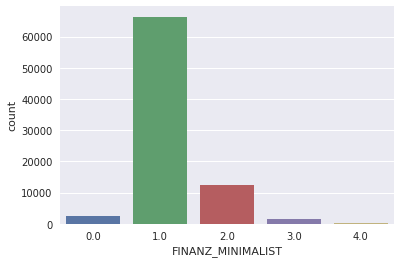

In [204]:
sns.countplot(inverted_cluster_df['FINANZ_MINIMALIST'])

A score of 1 is high. Thus, they are in this financial type. So the people who are not in our customer segment have a financial type.

### Discussion 3.3: Compare Customer Data to Demographics Data

##### Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?

Yes we can, have a look at the ratio and explanations in the previous cells.

The people who must be targeted for the business are usually religious and do not own a home.

And the people who the business should not use resources on are usually single.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.